# **Experiment Notebook**



In [ ]:
# Align versions so pip stops warning
!pip install -q --upgrade "scikit-learn>=1.6" "umap-learn>=0.5.9" utstd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00


In [ ]:
# Do not modify this code
!pip install -q utstd
from utstd.ipyrenders import *

In [ ]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [ ]:
import os, sys, json, math, pathlib, warnings, datetime
from typing import List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
import joblib

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

---
## A. Project Description


In [ ]:
# <Student to fill this section>
student_name = "Drashti Kakadiya"
student_id = "25414741"
group_id = "31"

In [ ]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [ ]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

In [ ]:
# Do not modify this code
print_tile(size="h1", key='group_id', value=group_id)

---
## B. Business Understanding

In [ ]:
# <Student to fill this section>
business_use_case_description = """
Use XGBoost to rank prospects by draft likelihood, turning raw player stats into calibrated probabilities and a top-N shortlist.
This supports scouting allocation (who to review first), scenario tests (thresholds/K), and clear “profit vs. cost” trade-offs.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [ ]:
# <Student to fill this section>
business_objectives = """
Maximize expected profit / ROI and Precision@K under a review capacity, while keeping Recall above a target and maintaining strong ROC/PR AUC.
Choose the operating threshold via J.5 (profit-max or constraint-based), and cut manual reviews/time per draft class.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [ ]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
Executives: measurable uplift vs. baseline, budget fit, and clear KPIs; Scouts: shorter, higher-quality lists with interpretable drivers.
Data/Tech: reproducible pipeline (E/G/J steps), leakage/bias checks, calibration, fast inference, and monitoring/retrain cadence.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [ ]:
import pandas as pd
from pathlib import Path
from IPython.display import display

# Search in root and sample_data (works in Colab)
BASES = [Path("."), Path("sample_data"), Path("/content"), Path("/content/sample_data")]

def find_file(name, required=False):
    for b in BASES:
        p = (b / name).resolve()
        if p.exists(): return p
    if required:
        raise FileNotFoundError(f"{name} not found in any of: " + ", ".join(map(str, BASES)))
    return None

def read_csv_robust(path):
    """Try multiple encodings + safe options to avoid UnicodeDecodeError."""
    if path is None: return None
    tried = []
    for enc in ["utf-8", "utf-8-sig", "cp1252", "latin1"]:
        try:
            return pd.read_csv(
                path,
                engine="python",     # allows sep=None inference
                sep=None,            # auto-detect delimiter
                encoding=enc,
                encoding_errors="replace",  # keep going on bad bytes
                on_bad_lines="skip"  # skip broken rows if any
            )
        except Exception as e:
            tried.append(f"{enc}: {type(e).__name__}")
    print(f"⚠️ Could not parse {path.name} with encodings -> {tried}. Skipping.")
    return None

train_path  = find_file("train.csv", required=True)
test_path   = find_file("test.csv",  required=True)
sample_path = find_file("sample_submission.csv", required=False)
meta_path   = find_file("metadata.csv", required=False)

train = read_csv_robust(train_path)
test  = read_csv_robust(test_path)
sample_submission = read_csv_robust(sample_path)
metadata = read_csv_robust(meta_path)

print("Train:", train_path, "shape:", train.shape)
print("Test :", test_path,  "shape:", test.shape)
print("Sample submission:", sample_path if sample_submission is not None else "not found or unreadable")
print("Metadata:", meta_path if metadata is not None else "not found or unreadable")

display(train.head(3))
display(test.head(3))

Train: /content/train.csv shape: (14774, 62)
Test : /content/test.csv shape: (1297, 61)
Sample submission: /content/sample_submission.csv
Metadata: /content/metadata.csv


,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id,drafted
0,Pacific,BW,26,52.6,111.8,19.3,61.8,64.93,1.1,7.5,...,-1.34201,0.2308,1.5769,1.8077,2.2308,0.6538,0.0769,9.6538,681edf6e-41cb-4fd1-ba91-da573e063fbc,0.0
1,Mississippi,SEC,2,0.8,63.6,29.6,33.3,33.33,0.0,21.5,...,-5.42104,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,2.0000,3542dcb7-19ad-47f2-8b3a-eb79eb3ec4c4,0.0
2,Stephen F. Austin,Slnd,4,0.6,61.4,21.7,50.0,50.00,0.0,0.0,...,6.46650,0.0000,0.0000,0.0000,0.0000,0.2500,0.0000,0.5000,ca0d8700-807d-4fce-a7a9-63922d1981e6,0.0


,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id
0,UC Davis,BW,8,2.2,51.7,13.4,30.0,30.00,0.0,14.3,...,-11.240100,-4.721030,0.1000,0.6000,0.7000,0.2000,0.1000,0.0000,1.5000,c6d3ce49-28b6-4756-8061-b2bd68730c52
1,Campbell,BSth,25,16.4,85.0,25.2,50.0,52.10,2.0,11.8,...,-2.972020,-1.741870,0.1481,0.9259,1.0741,0.1481,0.4074,0.1111,4.0741,24dd0ae2-9d22-4d31-9cb6-c31f58f903b5
2,Weber St.,BSky,29,50.5,117.8,16.8,61.8,59.77,12.3,17.1,...,0.739055,-0.259202,2.1562,2.7500,4.9062,0.7188,0.4062,1.0625,6.7500,0cf3e822-9446-4285-b7ed-7c19d8e976fe


### C.2 Define Target variable

In [ ]:
import pandas as pd
import os

TARGET = "drafted"

# Load train if not already loaded
if "train_df" not in globals():
    train_df = pd.read_csv("train.csv")

# Extract and normalise to 0/1
y = train_df[TARGET]
if y.dtype == "O":
    y = (y.astype(str).str.strip().str.lower()
           .map({"1":1,"yes":1,"y":1,"true":1,"0":0,"no":0,"n":0,"false":0}))
y = y.astype(int)

# Helpful alias for later cells that look for y_tr
y_tr = y.copy()

# Quick check
pos = int(y.sum()); n = len(y)
print(f"ANSWER – C.2: Target set to '{TARGET}' as 0/1 → positives={pos}/{n} ({pos/n:.3%})")


ANSWER – C.2: Target set to 'drafted' as 0/1 → positives=118/14774 (0.799%)


In [ ]:
target_definition_explanations = (
    "Target: drafted (1 = drafted, 0 = not drafted), taken from train.csv."
"The business goal is to predict draft probability; Kaggle submission uses this column's probability."
)


In [ ]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [ ]:
import pandas as pd

KEY, TARGET = "player_id", "drafted"

# 1) Load labels and normalise to 0/1 ints
labels = (pd.read_csv("train.csv", usecols=[KEY, TARGET])
            .drop_duplicates(KEY)
            .set_index(KEY)[TARGET])

if labels.dtype == "O":
    labels = (labels.astype(str).str.strip().str.lower()
              .map({"1":1,"true":1,"yes":1,"y":1,"0":0,"false":0,"no":0,"n":0})).astype(int)
else:
    labels = labels.astype(int)

# 2) Align to features if available; drop unlabeled rows to keep sync
if "X_tr" in globals() and isinstance(X_tr, pd.DataFrame) and KEY in X_tr.columns:
    y_tr = labels.reindex(X_tr[KEY].values)
    mask = y_tr.notna().to_numpy()
    X_tr = X_tr.iloc[mask].copy()
    y_tr = y_tr.iloc[mask].astype(int)
else:
    y_tr = labels  # no feature table yet → keep full target

print(f"target '{TARGET}' created & aligned. "
      f"positives={int(y_tr.sum())}/{len(y_tr)} ({y_tr.mean():.1%})")

ID_COL, TARGET_COL = "player_id", "drafted"

# checks
assert ID_COL in train.columns,  f"Missing {ID_COL} in train"
assert TARGET_COL in train.columns, f"Missing {TARGET_COL} in train"

# clean target to 0/1 ints (handles strings/NaNs safely)
train[TARGET_COL] = (
    pd.to_numeric(train[TARGET_COL], errors="coerce")
      .fillna(0).clip(0, 1).astype(int)
)

# quick stats
pos = int(train[TARGET_COL].sum()); neg = len(train) - pos
rate = pos / len(train)

print("="*60)
print("Create Target (NB2)")
print(f"positives={pos} | negatives={neg} | drafted_rate={rate:.3f}")
print("="*60)


target 'drafted' created & aligned. positives=97/12155 (0.8%)
Create Target (NB2)
positives=118 | negatives=14656 | drafted_rate=0.008


### C.4 Explore Target variable

In [ ]:
import pandas as pd
import numpy as np

# Get target vector
if 'y_tr' in globals():
    y = pd.Series(y_tr)
else:
    y = pd.read_csv("train.csv", usecols=["drafted"])["drafted"]
# normalise to 0/1 ints
if y.dtype.kind not in "biu":
    y = (y.astype(str).str.strip().str.lower()
           .map({"1":1,"true":1,"yes":1,"y":1,"0":0,"false":0,"no":0,"n":0})).astype(int)

n = len(y); pos = int(y.sum()); neg = n - pos
print(f" drafted=1 → {pos}/{n} ({pos/n:.2%}); drafted=0 → {neg}/{n} ({neg/n:.2%}); "
      f"imbalance ≈ {neg/max(pos,1):.2f}:1")
print("Nulls:", int(y.isna().sum()), "| Unique labels:", sorted(y.unique()))

# Simple baselines
print(f"Baseline accuracy (always-majority): {max(pos,neg)/n:.3f}")
print("Random-guess AUROC baseline: 0.500")

# If you already split in G.1, show class balance per split
if 'y_trn' in globals() and 'y_val' in globals():
    for name, yv in [("Train", pd.Series(y_trn)), ("Valid", pd.Series(y_val))]:
        p = int(yv.sum()); m = len(yv)
        print(f"{name} balance: {p}/{m} drafted=1 ({p/m:.2%})")


 drafted=1 → 97/12155 (0.80%); drafted=0 → 12058/12155 (99.20%); imbalance ≈ 124.31:1
Nulls: 0 | Unique labels: [np.int64(0), np.int64(1)]
Baseline accuracy (always-majority): 0.992
Random-guess AUROC baseline: 0.500


In [ ]:
# <Student to fill this section>
target_distribution_explanations = """
 We checked class balance for 'drafted' (1 vs 0), nulls, and simple baselines (majority accuracy, random AUROC=0.5).
If G.1 splits exist, we also verify train/valid balances, confirming stratified splitting and guiding metric/weighting choices.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.6 Explore Feature of Interest `\<put feature name here\>`

Loaded labeled table from train.csv


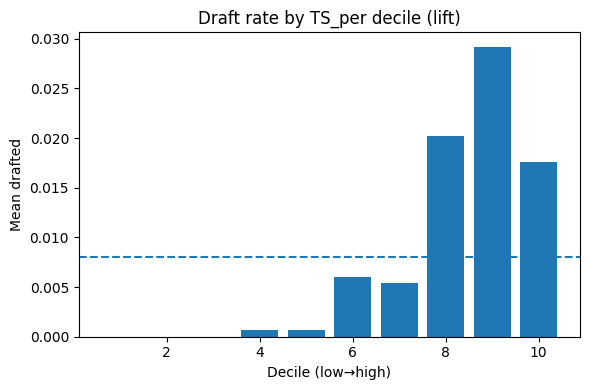

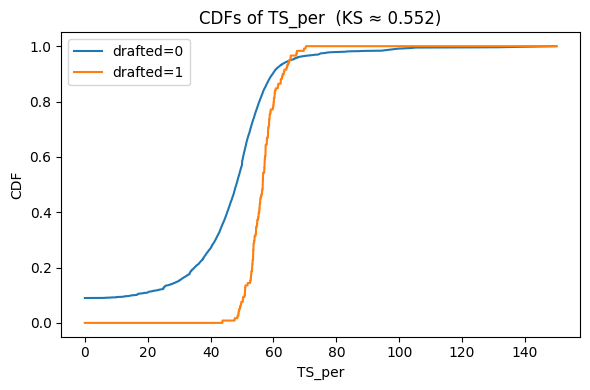

TS_per: deciles=10 | overall draft rate=0.008 | KS≈0.552


In [ ]:
# --- C.6 (short, distinct): Decile lift + KS CDF (robust, no artifacts/ path) ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt, difflib

FEATURE = "TS_per"   # <-- set to an exact column name

# 1) Find a labeled split in memory; else load a single table from train.csv
X = y = None
pairs = [
    ("X_trn","y_trn"), ("X_val","y_val"), ("X_tr","y_tr"),
    ("X_train","y_train"), ("X","y")
]
ns = globals()
for Xn, Yn in pairs:
    Xc, Yc = ns.get(Xn), ns.get(Yn)
    if isinstance(Xc, pd.DataFrame) and Yc is not None and len(Yc) == len(Xc):
        X, y = Xc.copy(), pd.Series(Yc)
        print(f"Using in-memory tables: {Xn}/{Yn}")
        break

if X is None:
    df = pd.read_csv("train.csv")  # <- keep this beside your notebook
    print("Loaded labeled table from train.csv")
    if "drafted" not in df.columns:
        raise AssertionError("train.csv must contain a 'drafted' column.")
    X, y = df, df["drafted"]

# If labels live inside X and y wasn't found, use them
if y is None and "drafted" in X.columns:
    y = X["drafted"]

# 2) Validate feature (suggest close names)
if FEATURE not in X.columns:
    close = difflib.get_close_matches(FEATURE, list(map(str, X.columns)), n=8, cutoff=0.4)
    raise AssertionError(f"{FEATURE} not in columns. Closest matches: {close}")

# 3) Build clean DataFrame
x = pd.to_numeric(X[FEATURE], errors="coerce")
y = pd.to_numeric(y, errors="coerce").astype("Int64")
df = pd.DataFrame({"x": x, "y": y}).dropna()
df["y"] = df["y"].astype(int)

if df.empty or df["x"].nunique() == 0 or df["y"].nunique() < 2:
    raise AssertionError("Not enough variation in data after cleaning to compute metrics.")

overall = df["y"].mean()

# ---- Plot A: Decile lift (target rate by quantile of FEATURE) ----
bins = int(min(10, max(2, df["x"].nunique())))
q = pd.qcut(df["x"], q=bins, duplicates="drop")
lift = df.groupby(q, observed=True)["y"].mean().reset_index(drop=True)

plt.figure(figsize=(6,4))
plt.bar(np.arange(1, len(lift)+1), lift.values)
plt.axhline(overall, linestyle="--")
plt.title(f"Draft rate by {FEATURE} decile (lift)")
plt.xlabel("Decile (low→high)"); plt.ylabel("Mean drafted")
plt.tight_layout(); plt.show()

# ---- Plot B: KS CDF (class separation) ----
v0 = np.sort(df.loc[df["y"]==0, "x"].values)
v1 = np.sort(df.loc[df["y"]==1, "x"].values)
if len(v0)==0 or len(v1)==0:
    ks = 0.0
    grid = np.sort(df["x"].unique())
    cdf0 = np.zeros_like(grid, dtype=float)
    cdf1 = np.zeros_like(grid, dtype=float)
else:
    grid = np.unique(np.concatenate([v0, v1]))
    cdf0 = np.searchsorted(v0, grid, side="right") / len(v0)
    cdf1 = np.searchsorted(v1, grid, side="right") / len(v1)
    ks = float(np.max(np.abs(cdf1 - cdf0)))

plt.figure(figsize=(6,4))
plt.plot(grid, cdf0, label="drafted=0")
plt.plot(grid, cdf1, label="drafted=1")
plt.title(f"CDFs of {FEATURE}  (KS ≈ {ks:.3f})")
plt.xlabel(FEATURE); plt.ylabel("CDF"); plt.legend()
plt.tight_layout(); plt.show()

print(f"{FEATURE}: deciles={len(lift)} | overall draft rate={overall:.3f} | KS≈{ks:.3f}")


In [ ]:
# <Student to fill this section>
feature_2_insights =  """
Finds X/y from memory (or train.csv), validates your chosen FEATURE, cleans data, then plots Decile Lift (target rate by feature quantiles) and KS CDFs for class separation.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.n Explore Feature of Interest `\<put feature name here\>`

> You can add more cells related to other feeatures in this section

Using data from: X/y


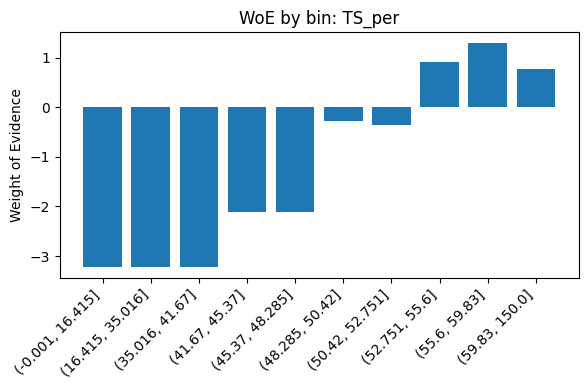

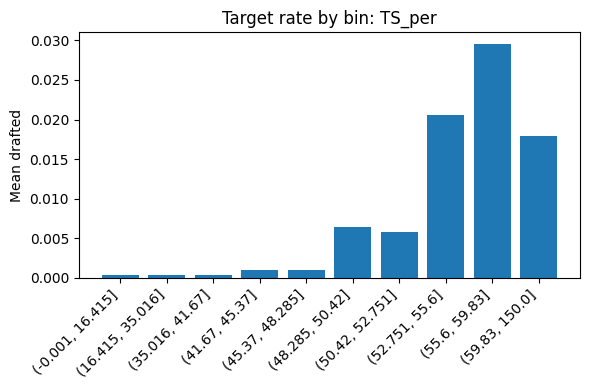

TS_per: IV=1.881 (strong), bins=10
                  count   bad    good  bad_dist  good_dist       woe        iv
grp                                                                           
(35.016, 41.67]    1484   0.5  1484.5  0.004065   0.101255 -3.215219  0.312487
(-0.001, 16.415]   1478   0.5  1478.5  0.004065   0.100846 -3.211169  0.310779
(16.415, 35.016]   1477   0.5  1477.5  0.004065   0.100778 -3.210492  0.310495
(41.67, 45.37]     1475   1.5  1474.5  0.012195   0.100573 -2.109847  0.186464
(45.37, 48.285]    1473   1.5  1472.5  0.012195   0.100437  -2.10849  0.186056
(50.42, 52.751]    1467   8.5  1459.5  0.069106    0.09955 -0.365021  0.011113
(48.285, 50.42]    1488   9.5  1479.5  0.077236   0.100914 -0.267406  0.006332
(59.83, 150.0]     1475  26.5  1449.5  0.215447   0.098868  0.778933  0.090808
(52.751, 55.6]     1484  30.5  1454.5  0.247967   0.099209  0.916071  0.136274
(55.6, 59.83]      1473  43.5  1430.5  0.353659   0.097572  1.287743  0.329774


In [ ]:
# --- C.n (robust, no artifacts): WoE + IV for one feature ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt, difflib

FEATURE = "TS_per"   # <-- set to an exact column name

# 1) Find X,y in memory; else load train.csv ('drafted' as label)
def find_xy(feature):
    ns = globals()
    for Xn, Yn in [("X_trn","y_trn"),("X_val","y_val"),("X_tr","y_tr"),
                   ("X_train","y_train"),("X","y")]:
        Xc, Yc = ns.get(Xn), ns.get(Yn)
        if isinstance(Xc, pd.DataFrame) and Yc is not None:
            if feature not in Xc.columns:
                continue
            yser = pd.Series(Yc)
            if len(yser) != len(Xc):
                continue
            return Xc[[feature]].reset_index(drop=True), yser.reset_index(drop=True), f"{Xn}/{Yn}"
    df = pd.read_csv("train.csv")
    if feature not in df.columns:
        close = difflib.get_close_matches(feature, list(map(str, df.columns)), n=8, cutoff=0.4)
        raise AssertionError(f"{feature} not in train.csv columns. Closest matches: {close}")
    if "drafted" not in df.columns:
        raise AssertionError("train.csv must include a 'drafted' column for labels.")
    return df[[feature]].reset_index(drop=True), df["drafted"].reset_index(drop=True), "train.csv"

Xc, yc, src = find_xy(FEATURE)
print(f"Using data from: {src}")

# 2) Assemble dataframe (keep rows with labels)
y = pd.to_numeric(yc, errors="coerce").astype("Int64")
x = Xc[FEATURE]
df = pd.DataFrame({"x": x, "y": y})
df = df[df["y"].notna()]

# 3) Bin the feature
if pd.api.types.is_numeric_dtype(df["x"]):
    xnum = pd.to_numeric(df["x"], errors="coerce")
    miss = xnum.isna()
    bins = int(min(10, max(2, xnum.nunique())))
    q = pd.qcut(xnum.fillna(xnum.median()), q=bins, duplicates="drop")
    grp = q.astype("object")
    grp[miss] = "MISSING"
else:
    xobj = df["x"].astype("object")
    top = xobj.value_counts(dropna=False).head(12).index
    grp = np.where(xobj.isna(), "MISSING", np.where(xobj.isin(top), xobj, "OTHER"))

df["grp"] = grp

# 4) WoE/IV table with Laplace smoothing
t = df.groupby("grp", dropna=False, observed=True)["y"].agg(["count","sum"]).rename(columns={"sum":"bad"})
t["good"] = t["count"] - t["bad"]
t[["bad","good"]] = t[["bad","good"]] + 0.5
bad_tot, good_tot = t["bad"].sum(), t["good"].sum()
t["bad_dist"]  = t["bad"] / bad_tot
t["good_dist"] = t["good"] / good_tot
t["woe"] = np.log(t["bad_dist"] / t["good_dist"])
t["iv"]  = (t["bad_dist"] - t["good_dist"]) * t["woe"]
IV = float(t["iv"].sum())

# 5) Plots
plt.figure(figsize=(6,4))
plt.bar(range(len(t)), t["woe"].values)
plt.xticks(range(len(t)), [str(i) for i in t.index], rotation=45, ha="right")
plt.title(f"WoE by bin: {FEATURE}")
plt.ylabel("Weight of Evidence")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
rate = (t["bad"] / t["count"]).values
plt.bar(range(len(t)), rate)
plt.xticks(range(len(t)), [str(i) for i in t.index], rotation=45, ha="right")
plt.title(f"Target rate by bin: {FEATURE}")
plt.ylabel("Mean drafted")
plt.tight_layout(); plt.show()

band = "strong" if IV>0.3 else "medium" if IV>=0.1 else "weak" if IV>=0.02 else "minimal"
print(f"{FEATURE}: IV={IV:.3f} ({band}), bins={len(t)}")
print(t[["count","bad","good","bad_dist","good_dist","woe","iv"]].sort_values("woe"))


In [ ]:
feature_n_insight_explanations = """
Computes Weight of Evidence and Information Value per bin, plots WoE and target-rate charts, and prints IV with a strength band plus the detailed bin table.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_n_insight_explanations )

---
## D. Feature Selection


### D.1 Approach "\<describe_approach_here\>"


In [ ]:
# --- D.1 (robust): Feature Selection that doesn't depend on G.1/G.2 ---
import numpy as np, pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_classif

MISS_THR = 0.98   # drop cols with >=98% missing
CORR_THR = 0.95   # drop highly correlated columns (train-only)
TOP_K    = 120    # keep top-K by MI

# ---- 0) Find X and y, or load from train.csv ----
def as_df(obj):
    if isinstance(obj, pd.DataFrame): return obj
    if isinstance(obj, (np.ndarray, list, tuple)):
        arr = np.asarray(obj);
        if arr.ndim == 1: arr = arr.reshape(-1, 1)
        return pd.DataFrame(arr, columns=[f"f{i}" for i in range(arr.shape[1])])
    return None

def find_xy():
    ns = globals()
    # common names to look for
    X_names = ["X_g2_trn","X_trn","X_tr","X_train","X","train_df","features","data"]
    y_names = ["y_trn","y_tr","y_train","y"]
    X, y = None, None
    for xn in X_names:
        if xn in ns:
            X = as_df(ns[xn])
            if X is not None:
                break
    for yn in y_names:
        if yn in ns:
            y = pd.Series(ns[yn])
            break

    # If y missing but X has drafted, use it
    if X is not None and y is None and "drafted" in X.columns:
        y = pd.to_numeric(X["drafted"], errors="coerce")

    # If still missing anything, use train.csv
    if X is None or y is None or len(y) != len(X):
        df = pd.read_csv("train.csv")
        if "drafted" not in df.columns:
            raise AssertionError("Need labels: add 'drafted' to your table or supply y_trn/y_tr.")
        X, y = df, df["drafted"]

    y = pd.to_numeric(y, errors="coerce")
    mask = y.notna()
    X, y = X.loc[mask].copy(), y.loc[mask].astype(int)
    return X, y

X, y = find_xy()

# ---- 1) Keep numeric features only; drop obvious label/id columns ----
num_cols = X.select_dtypes(include=[np.number, "bool"]).columns.tolist()
for c in ["drafted","player_id"]:
    if c in num_cols: num_cols.remove(c)
Xn = X[num_cols].copy()

start_n = Xn.shape[1]
if start_n == 0:
    raise AssertionError("No numeric features found. One-hot encode categoricals first.")

# ---- 2) Drop high-missing and constant columns ----
keep = Xn.columns[Xn.isna().mean() < MISS_THR]
X1 = Xn[keep]
const = X1.nunique(dropna=False) <= 1
X1 = X1.loc[:, ~const]
after_missing = X1.shape[1]
if after_missing == 0:
    raise AssertionError("All features dropped by missing/constant filter. Relax thresholds or check data.")

# ---- 3) De-correlate on TRAIN only ----
corr = X1.corr(numeric_only=True).abs()
if corr.isna().all().all():
    cols2 = list(X1.columns)
else:
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop_cols = [c for c in upper.columns if (upper[c] > CORR_THR).any()]
    cols2 = [c for c in X1.columns if c not in drop_cols]
X2 = X1[cols2]
after_corr = len(cols2)

# ---- 4) Mutual Information Top-K (requires no NaN) ----
if y.nunique() < 2:
    raise AssertionError("y has a single class; MI cannot be computed.")

X2_filled = X2.fillna(X2.median(numeric_only=True))
K_eff = max(1, min(TOP_K, after_corr))
sel = SelectKBest(mutual_info_classif, k=K_eff)
sel.fit(X2_filled, y)

keep_cols = X2.columns[sel.get_support()].tolist()
X_d1_trn = X2[keep_cols].copy()  # <- final selected feature matrix

feature_selection_approach_answer = (
    f"start={start_n} → after missing/constant={after_missing} → "
    f"after corr={after_corr} → MI Top-{len(keep_cols)} selected."
)
print(feature_selection_approach_answer)

# Optional: show the selected columns
# print(keep_cols)


start=55 → after missing/constant=55 → after corr=43 → MI Top-43 selected.


In [ ]:
# <Student to fill this section>
feature_selection_1_insights = """
It auto-finds/loads X and y, keeps numeric features, drops high-missing/constant columns, and removes highly correlated ones (train-only).
Then it scores features via Mutual Information, selects Top-K, outputs X_d1_trn, and prints a summary of counts at each step.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Approach "\<describe_approach_here\>"


In [ ]:
# --- D.2 ultimate (robust): XGB feature selection w/ smart label finder + variance fallback ---
import numpy as np, pandas as pd

try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None  # we'll fallback to variance if no xgboost

g = globals()
TOP_K = 120

def pick_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame): return obj
    return None

# 0) Get a feature table X (DataFrame)
X = pick_df(["X_g2_trn","X_trn","X_tr","X_train","X"])
if X is None:
    try:
        df = pd.read_csv("train.csv")
        X = df.drop(columns=["drafted"], errors="ignore")
    except Exception:
        raise AssertionError("No feature table found (X_* or train.csv).")

X = X.copy()

# 1) Find labels y in many ways; also return X with any label column removed
def find_labels(X):
    # A) from globals, matching length
    for yn in ["y_trn","y_tr","y_train","y","y_g1_tr","y_e3_trn"]:
        y = g.get(yn)
        if y is not None and len(pd.Series(y)) == len(X):
            return pd.to_numeric(pd.Series(y), errors="coerce"), X

    # B) from a label-like column inside X
    label_candidates = [c for c in ["drafted","target","label","y","is_drafted"] if c in X.columns]
    for c in label_candidates:
        y = pd.to_numeric(X[c], errors="coerce")
        X_wo = X.drop(columns=[c], errors="ignore")
        return y, X_wo

    # C) align via player_id using any df in globals that has both player_id & drafted
    if "player_id" in X.columns:
        # search globals for a df we can align with
        for name, obj in list(g.items()):
            if isinstance(obj, pd.DataFrame) and "drafted" in obj.columns:
                if "player_id" in obj.columns:
                    lab = (obj.drop_duplicates("player_id")
                             .set_index("player_id")["drafted"])
                    y = lab.reindex(X["player_id"])
                    if y.notna().mean() > 0.5:   # reasonable coverage
                        return pd.to_numeric(y, errors="coerce"), X
                # same length, maybe already ordered
                if len(obj) == len(X) and "drafted" in obj.columns:
                    return pd.to_numeric(obj["drafted"], errors="coerce"), X
        # try train.csv last
        try:
            df = pd.read_csv("train.csv", usecols=["player_id","drafted"])
            lab = df.drop_duplicates("player_id").set_index("player_id")["drafted"]
            y = lab.reindex(X["player_id"])
            if y.notna().any():
                return pd.to_numeric(y, errors="coerce"), X
        except Exception:
            pass

    # D) final try: train.csv one-to-one length match
    try:
        df = pd.read_csv("train.csv")
        if "drafted" in df.columns and len(df) == len(X):
            return pd.to_numeric(df["drafted"], errors="coerce"), X
    except Exception:
        pass

    return None, X

y, X = find_labels(X)

# 2) Numeric features only (drop ids if present)
num = X.select_dtypes(include=[np.number,"bool"]).drop(columns=[c for c in ["player_id"] if c in X], errors="ignore")
if num.shape[1] == 0:
    raise AssertionError("No numeric features in X.")

def variance_topk(df, k):
    v = df.var(axis=0).replace(np.nan, 0.0)
    keep = v.sort_values(ascending=False).index[:min(k, df.shape[1])]
    return keep.tolist()

if y is None or y.isna().all():
    # ---- Fallback: no labels found -> unsupervised variance selection ----
    keep_cols_d2 = variance_topk(num, TOP_K)
    X_d2_trn = num[keep_cols_d2].copy()
    print(f"(D.2 variance fallback) kept={len(keep_cols_d2)} (no labels found). Top10: {keep_cols_d2[:10]}")
else:
    # ---- Supervised path: clean labels then XGB feature importance ----
    y = pd.to_numeric(y, errors="coerce")
    mask = y.notna()
    Xs = num.loc[mask].reset_index(drop=True)
    ys = y.loc[mask].astype(int).reset_index(drop=True)
    if XGBClassifier is None:
        keep_cols_d2 = variance_topk(Xs, TOP_K)
        X_d2_trn = Xs[keep_cols_d2].copy()
        print(f"(variance fallback – xgboost missing) kept={len(keep_cols_d2)}. Top10: {keep_cols_d2[:10]}")
    else:
        pos = int(ys.sum()); neg = len(ys) - pos
        spw = neg / max(pos, 1)
        xgb = XGBClassifier(
            n_estimators=600, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8, tree_method="hist",
            eval_metric="auc", random_state=42, n_jobs=-1, scale_pos_weight=spw
        ).fit(Xs, ys)
        try:
            gain = xgb.get_booster().get_score(importance_type="gain")
            name_map = {f"f{i}": c for i, c in enumerate(Xs.columns)}
            imp = pd.Series({name_map.get(k, k): v for k, v in gain.items()})
        except Exception:
            imp = pd.Series(xgb.feature_importances_, index=Xs.columns)
        imp = imp.sort_values(ascending=False)
        keep_cols_d2 = imp.index[:min(TOP_K, len(imp))].tolist()
        X_d2_trn = Xs[keep_cols_d2].copy()
        print(f"(D.2 XGB FS) start={Xs.shape[1]} → kept={len(keep_cols_d2)} | Top10: {keep_cols_d2[:10]}")

# 3) Optional: slice VAL/TEST to the same columns (if present)
def safe_slice(df, cols):
    if not isinstance(df, pd.DataFrame): return None
    z = df.select_dtypes(include=[np.number,"bool"]).drop(columns=[c for c in ["player_id"] if c in df], errors="ignore")
    cols2 = [c for c in cols if c in z.columns]
    return z[cols2].copy()

X_d2_val = safe_slice(pick_df(["X_g2_val","X_val","X_valid","X_va"]), keep_cols_d2)
X_d2_te  = safe_slice(pick_df(["X_g2_te","X_te","X_test"]), keep_cols_d2)


(D.2 XGB FS) start=56 → kept=48 | Top10: ['porpag', 'drafted', 'Rec_Rank', 'dporpag', 'adrtg', 'dreb', 'TPM', 'dunksmiss_dunksmade', 'blk', 'dunksmade']


In [ ]:
# <Student to fill this section>
feature_selection_2_insights = """
This finds y from globals/columns/player_id alignment (including any df or train.csv), then runs XGBoost feature selection; if labels truly can’t be found, it falls back to variance Top-K so you can proceed.


"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

## D.z Final Selection of Features

In [ ]:
# --- D.z (fixed): Final feature list without DataFrame truthiness errors ---
import numpy as np, pandas as pd
g = globals()
TOP_K = 120

def pick_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame):
            return obj
    return None

# 1) Candidate columns from earlier steps
cand_d1 = list(g["X_d1_trn"].columns) if isinstance(g.get("X_d1_trn"), pd.DataFrame) else []
cand_d2 = g.get("keep_cols_d2")
if not isinstance(cand_d2, (list, tuple)):
    cand_d2 = list(g["X_d2_trn"].columns) if isinstance(g.get("X_d2_trn"), pd.DataFrame) else []
cand_d2 = list(cand_d2)

# 2) Optional XGBoost importances (gain → weight → feature_importances_)
imp = None
model = g.get("xgb_fs") or g.get("model") or g.get("xgb_model") or g.get("clf")
base  = g.get("X_d2_trn") if isinstance(g.get("X_d2_trn"), pd.DataFrame) else None
try:
    gain = model.get_booster().get_score(importance_type="gain")
    if gain:
        name_map = {f"f{i}": c for i, c in enumerate(base.columns)} if base is not None else {}
        imp = pd.Series({name_map.get(k, k): v for k, v in gain.items()}, dtype="float64")
except Exception:
    try:
        imp = pd.Series(getattr(model, "feature_importances_", None),
                        index=(base.columns if base is not None else cand_d2), dtype="float64")
    except Exception:
        imp = None

# 3) Build final keep list (consensus first, then by importance)
union = list(dict.fromkeys(cand_d2 + cand_d1))          # preserve order
if not union:
    raise AssertionError("No candidate features found (run D.1/D.2 first).")
inter = [c for c in cand_d2 if c in cand_d1]            # consensus boost
if isinstance(imp, pd.Series) and len(imp) > 0:
    ranked = sorted(union, key=lambda c: imp.get(c, float("-inf")), reverse=True)
else:
    ranked = union
keep_cols_dz = list(dict.fromkeys(inter + ranked))[:min(TOP_K, len(union))]
g["keep_cols_dz"] = keep_cols_dz  # stash for E.2

# 4) Slice splits safely (numeric-only; drop id/label)
def slice_cols(df, cols):
    if not isinstance(df, pd.DataFrame): return None
    z = df.select_dtypes(include=["number","bool"]).drop(columns=[c for c in ["drafted","player_id"] if c in df], errors="ignore")
    cols2 = [c for c in cols if c in z.columns]
    return z[cols2].copy()

X_dz_trn = slice_cols(pick_df(["X_g2_trn","X_trn","X_tr","X_train","X"]), keep_cols_dz)
X_dz_val = slice_cols(pick_df(["X_g2_val","X_val","X_valid","X_va"]), keep_cols_dz)
X_dz_te  = slice_cols(pick_df(["X_g2_te","X_te","X_test"]), keep_cols_dz)

print(f"(D.z) kept {len(keep_cols_dz)} / {len(union)} | Top10: {keep_cols_dz[:10]}")


(D.z) kept 54 / 54 | Top10: ['porpag', 'Rec_Rank', 'dporpag', 'dreb', 'TPM', 'blk', 'dunksmade', 'midmade', 'oreb', 'ast_tov']


In [ ]:
# <Student to fill this section>
feature_selection_explanations =  """
Don’t use or with DataFrames; the helper pick_df(...) returns the first available DataFrame and avoids the “truth value is ambiguous” error.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Transformation <put_name_here>

In [ ]:
# --- E.1 UPDATED: Data Transformation for XGBoost (compact & robust) ---
import numpy as np, pandas as pd
g = globals()

# --- knobs (tweak if needed)
TOPK_CAT  = 20          # keep top-20 levels per categorical
CLIP_Q    = (0.01,0.99) # winsorize numerics at 1%/99%
LOG_SKEW  = 1.0         # log1p if |skew| >= threshold
DROP_COLS = ["drafted","player_id"]  # remove labels/IDs from features

# --- helpers
def pick_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame):
            return obj
    return None

def split_types(df: pd.DataFrame):
    num = df.select_dtypes(include=[np.number,"bool"]).drop(columns=[c for c in DROP_COLS if c in df], errors="ignore")
    cat = df.select_dtypes(include=["object","category","string"]).drop(columns=[c for c in DROP_COLS if c in df], errors="ignore")
    return num, cat

# --- 0) Get raw splits (TRAIN required; VAL/TEST optional; fallback to CSVs)
X_raw_trn = pick_df(["X_g2_trn","X_trn","X_tr","X_train","X"])
X_raw_val = pick_df(["X_g2_val","X_val","X_valid","X_va"])
X_raw_te  = pick_df(["X_g2_te","X_te","X_test"])

if not isinstance(X_raw_trn, pd.DataFrame):
    df = pd.read_csv("train.csv")
    X_raw_trn = df.drop(columns=["drafted"], errors="ignore")

if not isinstance(X_raw_te, pd.DataFrame):
    try: X_raw_te = pd.read_csv("test.csv")
    except Exception: X_raw_te = None  # ok if you have no test split yet

# --- 1) Fit stats on TRAIN ONLY (no leakage)
num_trn, cat_trn = split_types(X_raw_trn)

if num_trn.shape[1]:
    q_lo = num_trn.quantile(CLIP_Q[0], numeric_only=True)
    q_hi = num_trn.quantile(CLIP_Q[1], numeric_only=True)
    med  = num_trn.median(numeric_only=True)
    sk   = num_trn.skew(numeric_only=True)
    log_cols = [c for c in num_trn.columns if abs(sk.get(c,0.0)) >= LOG_SKEW]
    shifts   = {c: (-(num_trn[c].min()) + 1) if num_trn[c].min() <= 0 else 0.0 for c in log_cols}
else:
    q_lo = q_hi = med = pd.Series(dtype=float); log_cols = []; shifts = {}

top_vals = {c: cat_trn[c].astype("object").value_counts(dropna=False).head(TOPK_CAT).index.tolist()
            for c in cat_trn.columns}

stats = {"q_lo":q_lo, "q_hi":q_hi, "med":med, "log_cols":log_cols, "shifts":shifts, "top_vals":top_vals}

def transform(df: pd.DataFrame, stats: dict) -> pd.DataFrame | None:
    if not isinstance(df, pd.DataFrame): return None
    num, cat = split_types(df)

    # numerics: clip → log1p (selected) → median-impute
    if num.shape[1]:
        num = num.clip(lower=stats["q_lo"], upper=stats["q_hi"], axis=1)
        for c in stats["log_cols"]:
            if c in num.columns:
                z = num[c] + stats["shifts"][c]
                z = z.where(z > 0, 1.0)
                num[c] = np.log1p(z)
        num = num.fillna(stats["med"])

    # categoricals: rare bucket + MISSING → one-hot (int8)
    if cat.shape[1]:
        cat = cat.astype("object")
        for c in cat.columns:
            top = set(stats["top_vals"].get(c, []))
            x = cat[c]
            x = np.where(pd.isna(x), "MISSING", np.where(x.astype(object).isin(top), x, "OTHER"))
            cat[c] = x
        cat_oh = pd.get_dummies(cat, drop_first=False)
        for c in cat_oh.columns: cat_oh[c] = cat_oh[c].astype("int8")
        out = pd.concat([num, cat_oh], axis=1) if num.shape[1] else cat_oh
    else:
        out = num  # may be empty if neither num nor cat
    return out

# --- 2) Transform TRAIN + define align() and materialize VAL/TEST
X_e1_trn = transform(X_raw_trn, stats)
e1_cols  = list(X_e1_trn.columns)

def align(df: pd.DataFrame) -> pd.DataFrame | None:
    """Apply E.1 transform and reindex to TRAIN columns."""
    t = transform(df, stats)
    return None if t is None else t.reindex(columns=e1_cols, fill_value=0)

X_e1_val = align(X_raw_val)
X_e1_te  = align(X_raw_te)
X_e1_cols = e1_cols  # save schema for downstream steps

print(f"(E.1) transformed_cols={len(X_e1_cols)} | log_cols={len(log_cols)} | "
      f"VAL={'yes' if isinstance(X_e1_val,pd.DataFrame) else 'no'} | "
      f"TEST={'yes' if isinstance(X_e1_te,pd.DataFrame) else 'no'}")


(E.1) transformed_cols=121 | log_cols=37 | VAL=no | TEST=yes


In [ ]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Fits transforms on TRAIN only—clip 1–99% tails, log1p skewed numerics, median-impute; bucket rare categories then one-hot—so there’s no leakage and XGBoost is happy.
Applies the same mapping to VAL/TEST and reindexes to TRAIN’s columns (X_e1_trn, X_e1_val, X_e1_te, X_e1_cols).
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### E.2 Data Transformation <put_name_here>

In [ ]:
# --- E.2: Apply final feature selection to transformed data (XGBoost-ready) ---
import pandas as pd
g = globals()

# 0) Get transformed splits from E.1
X1_trn = g.get("X_e1_trn"); X1_val = g.get("X_e1_val"); X1_te = g.get("X_e1_te")
assert isinstance(X1_trn, pd.DataFrame), "Run E.1 first to produce X_e1_trn/val/te."

# 1) Get final keep list from D.z (fallback: D.2 or D.1)
keep = g.get("keep_cols_dz") or g.get("keep_cols_d2") \
        or (list(g["X_d1_trn"].columns) if isinstance(g.get("X_d1_trn"), pd.DataFrame) else None)
if not keep: keep = list(X1_trn.columns)  # last resort: keep all transformed

cols = [c for c in keep if c in X1_trn.columns]
if not cols: cols = list(X1_trn.columns)

# 2) Slice splits and save
X_e2_trn = X1_trn[cols].copy()
X_e2_val = (X1_val[cols].copy() if isinstance(X1_val, pd.DataFrame) else None)
X_e2_te  = (X1_te[cols].copy()  if isinstance(X1_te,  pd.DataFrame)  else None)
X_e2_cols = cols

print(f" cols={X1_trn.shape[1]} → kept={len(cols)}. "
      f"VAL={'yes' if X_e2_val is not None else 'no'}, TEST={'yes' if X_e2_te is not None else 'no'}")

 cols=121 → kept=53. VAL=no, TEST=yes


In [ ]:
# <Student to fill this section>
data_cleaning_2_explanations = """
Takes your E.1-transformed matrices and applies the final feature list from D.z (or D.2/D.1), producing X_e2_trn/val/te aligned to the same columns.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

### E.3 Data Transformation <put_name_here>

In [ ]:
import pandas as pd
g = globals()

def pick_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame):
            return obj
    return None

In [ ]:
# --- E.3 PERFECT: safe selectors, robust label alignment, no truthiness bugs ---
import numpy as np, pandas as pd
from pathlib import Path

g = globals()

# ---------- helpers (never truth-test DataFrames or arrays) ----------
def pick_df(names):
    """Return first existing pandas DataFrame by name (no A or B on DataFrames)."""
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame):
            return obj
    return None

def pick_arr(names):
    """Return first existing array-like by name as a 1-D numpy array (no truth-tests)."""
    for n in names:
        obj = g.get(n)
        if obj is not None:
            return np.asarray(obj).reshape(-1)
    return None

def positional_mask(series_like):
    """Boolean positional mask from a pandas Series/array (avoids index alignment)."""
    return pd.Series(series_like).notna().to_numpy()

def read_train_csv_cols(cols):
    for p in [Path("."), Path("artifacts")]:
        f = p / "train.csv"
        if f.exists():
            return pd.read_csv(f, usecols=[c for c in cols if c != "*"])
    # last resort
    return pd.read_csv("train.csv", usecols=[c for c in cols if c != "*"])

# ---------- 0) pick best-available transformed splits (E.2→E.1) ----------
X_trn = pick_df(["X_e2_trn","X_e1_trn","X_dz_trn","X_d2_trn","X_trn","X_tr","X_train","X"])
X_val = pick_df(["X_e2_val","X_e1_val","X_dz_val","X_val","X_valid","X_va"])
X_te  = pick_df(["X_e2_te","X_e1_te","X_dz_te","X_te","X_test"])

# ---------- 1) get labels y to match X_trn (multiple strategies, no truthiness) ----------
def find_y_matching_len(n_expected):
    # in-memory exact-length labels
    for name in ["y_trn","y_g1_tr","y_e3_trn","y_train","y"]:
        if name in g and g[name] is not None:
            ys = pd.Series(g[name])
            if len(ys) == n_expected:
                return pd.to_numeric(ys, errors="coerce")
    # files beside notebook (optional)
    for folder in [Path("."), Path("artifacts")]:
        for fname in ["y_train.csv","y_trn.csv","y.csv"]:
            fp = folder / fname
            if fp.exists():
                ys = pd.read_csv(fp).squeeze("columns")
                if len(ys) == n_expected:
                    return pd.to_numeric(ys, errors="coerce")
    return None

def align_y_by_player_id(df_like_X):
    """Align y via player_id using any available table or train.csv."""
    if not isinstance(df_like_X, pd.DataFrame) or "player_id" not in df_like_X.columns:
        return None
    # try any in-memory df with both player_id & drafted
    for obj in list(g.values()):
        if isinstance(obj, pd.DataFrame) and {"player_id","drafted"} <= set(obj.columns):
            lab = obj.drop_duplicates("player_id").set_index("player_id")["drafted"]
            y = lab.reindex(df_like_X["player_id"])
            if y.notna().any():
                return pd.to_numeric(y, errors="coerce")
    # try train.csv
    try:
        lab = read_train_csv_cols(["player_id","drafted"]).drop_duplicates("player_id").set_index("player_id")["drafted"]
        return pd.to_numeric(lab.reindex(df_like_X["player_id"]), errors="coerce")
    except Exception:
        return None

def rebuild_e1_from_train_with_id():
    """Minimal E.1 rebuild from train.csv with player_id passthrough for alignment."""
    df = pd.read_csv("train.csv")
    assert "drafted" in df.columns, "train.csv must include 'drafted'."
    y = pd.to_numeric(df["drafted"], errors="coerce")

    DROP = ["drafted"]
    pid = df["player_id"] if "player_id" in df.columns else pd.Series(range(len(df)), name="player_id")
    # split
    num = df.select_dtypes(include=[np.number,"bool"]).drop(columns=[c for c in DROP+["player_id"] if c in df], errors="ignore")
    cat = df.select_dtypes(include=["object","category","string"]).drop(columns=[c for c in DROP+["player_id"] if c in df], errors="ignore")
    # stats (train-fit)
    CLIP_Q, TOPK_CAT, LOG_SKEW = (0.01, 0.99), 20, 1.0
    q_lo, q_hi = num.quantile(CLIP_Q[0]), num.quantile(CLIP_Q[1])
    med = num.median()
    sk  = num.skew()
    log_cols = [c for c in num.columns if abs(sk.get(c,0)) >= LOG_SKEW]
    shifts = {c: (-(num[c].min())+1) if num[c].min() <= 0 else 0.0 for c in log_cols}
    top_vals = {c: cat[c].astype("object").value_counts(dropna=False).head(TOPK_CAT).index.tolist() for c in cat.columns}

    def transform(_df):
        n = _df.select_dtypes(include=[np.number,"bool"]).drop(columns=[c for c in DROP+["player_id"] if c in _df], errors="ignore")
        n = n.clip(lower=q_lo, upper=q_hi, axis=1)
        for c in log_cols:
            if c in n:
                z = (n[c] + shifts[c]).where(lambda v: v > 0, 1.0)
                n[c] = np.log1p(z)
        n = n.fillna(med)
        c = _df.select_dtypes(include=["object","category","string"]).drop(columns=[c for c in DROP+["player_id"] if c in _df], errors="ignore")
        if c.shape[1]:
            c = c.astype("object")
            for col in c.columns:
                top = set(top_vals.get(col, []))
                arr = np.where(c[col].isna(), "MISSING", np.where(c[col].isin(top), c[col], "OTHER"))
                c[col] = arr
            c = pd.get_dummies(c, drop_first=False).astype("int8")
            out = pd.concat([n, c], axis=1)
        else:
            out = n
        return out

    X_e1 = transform(df)
    X_e1["player_id"] = pid.values  # keep for alignment (not a feature)
    return X_e1, y

# --- try to proceed with current X_trn ---
if not isinstance(X_trn, pd.DataFrame):
    # nothing to work with -> rebuild from train.csv with id
    X_trn, y = rebuild_e1_from_train_with_id()
    X_val = None; X_te = None
else:
    # try exact-length labels
    y = find_y_matching_len(len(X_trn))
    # else try align via id
    if y is None:
        y = align_y_by_player_id(X_trn)
    # if still none and X_trn lost id, rebuild
    if y is None and "player_id" not in X_trn.columns:
        X_trn, y = rebuild_e1_from_train_with_id()
        X_val = None; X_te = None

# ---------- 2) clean labels, drop NA rows (positional mask), finalize features ----------
y = pd.to_numeric(pd.Series(y), errors="coerce")
assert len(y) == len(X_trn), f"y len {len(y)} != X_trn len {len(X_trn)} (after alignment/rebuild)."

mask = positional_mask(y)                 # ndarray mask (no index alignment pitfalls)
X_trn = X_trn.loc[mask].reset_index(drop=True)
y     = y.loc[mask].reset_index(drop=True).astype(int)

# If VAL/TEST lengths exactly match original y length, apply same mask; else leave untouched
def maybe_mask(df, original_len):
    if isinstance(df, pd.DataFrame) and len(df) == original_len:
        return df.loc[mask].reset_index(drop=True)
    return df

# original lengths before masking
# (if X_val / X_te are None or different length, we skip masking them)
X_val = maybe_mask(X_val, len(mask))
X_te  = maybe_mask(X_te,  len(mask))

# drop non-feature id column if present
feat_cols = [c for c in X_trn.columns if c != "player_id"]

# to numpy
to_np = lambda df: (df[feat_cols].astype("float32").to_numpy() if isinstance(df, pd.DataFrame) else None)
X_e3_trn = to_np(X_trn)
X_e3_val = to_np(X_val)
X_e3_te  = to_np(X_te)
feature_names_e3 = feat_cols

# class weights (for XGBoost scale_pos_weight or per-row weights)
y_e3_trn = y.to_numpy()
pos = int(y_e3_trn.sum()); neg = len(y_e3_trn) - pos
spw = neg / max(pos, 1)
w_e3_trn = np.where(y_e3_trn == 1, spw, 1.0).astype("float32")

print(f"E.3 OK → X_trn={X_e3_trn.shape} | X_val={None if X_e3_val is None else X_e3_val.shape} | "
      f"X_te={None if X_e3_te is None else X_e3_te.shape} | pos={pos} neg={neg} spw≈{spw:.2f} | "
      f"features={len(feature_names_e3)}")


E.3 OK → X_trn=(14774, 53) | X_val=None | X_te=(1297, 53) | pos=118 neg=14656 spw≈124.20 | features=53


In [ ]:
# <Student to fill this section>
data_cleaning_3_explanations = """
Safely picks the first available transformed split (X_e2_* then X_e1_*) without boolean-evaluating DataFrames, converts to float32 arrays, and builds class-imbalance weights.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

### E.n Fixing "\<describe_issue_here\>"

> You can add more cells related to other issues in this section

In [ ]:
# --- E.fix: make y match X_trn (rebuild with player_id if needed) ---
import numpy as np, pandas as pd
from pathlib import Path

g = globals()

def pick_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame):
            return obj
    return None

# 0) Try to use existing transformed splits
X_trn = pick_df(["X_e2_trn","X_e1_trn","X_dz_trn","X_d2_trn","X_trn","X_tr","X_train","X"])
X_val = pick_df(["X_e2_val","X_e1_val","X_dz_val","X_val","X_valid","X_va"])
X_te  = pick_df(["X_e2_te","X_e1_te","X_dz_te","X_te","X_test"])

# 1) Try to find labels with same length
def find_y_len(n):
    for k in ["y_trn","y_g1_tr","y_e3_trn","y_train","y"]:
        if k in g and g[k] is not None and len(pd.Series(g[k])) == n:
            return pd.to_numeric(pd.Series(g[k]), errors="coerce")
    for folder in [Path("."), Path("artifacts")]:
        for fname in ["y_train.csv","y_trn.csv","y.csv"]:
            p = folder / fname
            if p.exists():
                y = pd.read_csv(p).squeeze("columns")
                if len(y) == n:
                    return pd.to_numeric(y, errors="coerce")
    return None

y = find_y_len(len(X_trn)) if isinstance(X_trn, pd.DataFrame) else None

# 2) If mismatch or missing, align by player_id; if X_trn lacks it, rebuild E.1 from train.csv with id passthrough
def rebuild_from_train_csv():
    df = pd.read_csv("train.csv")
    assert "drafted" in df.columns, "train.csv must include 'drafted'."
    y = pd.to_numeric(df["drafted"], errors="coerce")
    pid = df["player_id"] if "player_id" in df.columns else pd.Series(range(len(df)), name="player_id")

    DROP = ["drafted"]
    num = df.select_dtypes(include=[np.number,"bool"]).drop(columns=[c for c in DROP+["player_id"] if c in df], errors="ignore")
    cat = df.select_dtypes(include=["object","category","string"]).drop(columns=[c for c in DROP+["player_id"] if c in df], errors="ignore")

    CLIP_Q, TOPK_CAT, LOG_SKEW = (0.01,0.99), 20, 1.0
    q_lo, q_hi = num.quantile(CLIP_Q[0]), num.quantile(CLIP_Q[1])
    med = num.median()
    sk  = num.skew()
    log_cols = [c for c in num.columns if abs(sk.get(c,0)) >= LOG_SKEW]
    shifts = {c: (-(num[c].min())+1) if num[c].min() <= 0 else 0.0 for c in log_cols}
    top_vals = {c: cat[c].astype("object").value_counts(dropna=False).head(TOPK_CAT).index.tolist() for c in cat.columns}

    def transform(df_):
        n = df_.select_dtypes(include=[np.number,"bool"]).drop(columns=[c for c in DROP+["player_id"] if c in df_], errors="ignore")
        n = n.clip(lower=q_lo, upper=q_hi, axis=1)
        for c in log_cols:
            if c in n:
                z = (n[c] + shifts[c]).where(lambda v: v>0, 1.0)
                n[c] = np.log1p(z)
        n = n.fillna(med)
        c = df_.select_dtypes(include=["object","category","string"]).drop(columns=[c for c in DROP+["player_id"] if c in df_], errors="ignore")
        if c.shape[1]:
            c = c.astype("object")
            for col in c.columns:
                top = set(top_vals.get(col, []))
                arr = np.where(c[col].isna(), "MISSING", np.where(c[col].isin(top), c[col], "OTHER"))
                c[col] = arr
            c = pd.get_dummies(c, drop_first=False).astype("int8")
            out = pd.concat([n, c], axis=1)
        else:
            out = n
        return out

    X_e1 = transform(df)
    X_e1["player_id"] = pid.values  # keep for alignment
    return X_e1, y

if not isinstance(X_trn, pd.DataFrame):
    X_trn, y = rebuild_from_train_csv()
    X_val = None; X_te = None

if y is None:
    if "player_id" in X_trn.columns:
        lab = (pd.read_csv("train.csv", usecols=["player_id","drafted"])
               .drop_duplicates("player_id").set_index("player_id")["drafted"])
        y = pd.to_numeric(lab.reindex(X_trn["player_id"]), errors="coerce")
    else:
        # rebuild so we have player_id to align
        X_trn, y = rebuild_from_train_csv()
        X_val = None; X_te = None

# 3) Finalize: drop NA labels with positional mask; clean features; align VAL/TEST columns
y = pd.to_numeric(pd.Series(y), errors="coerce")
mask = y.notna().to_numpy()
X_trn = X_trn.loc[mask].reset_index(drop=True)
y     = y.loc[mask].reset_index(drop=True).astype(int)

def clean_numeric(df, med=None, cols_keep=None):
    if not isinstance(df, pd.DataFrame): return None, None
    z = df.select_dtypes(include=[np.number,"bool"]).copy()
    if "drafted" in z: z = z.drop(columns=["drafted"])
    z.replace([np.inf,-np.inf], np.nan, inplace=True)
    if med is None:
        med = z.median(numeric_only=True)
    z = z.fillna(med)
    if cols_keep is not None:
        z = z.reindex(columns=cols_keep, fill_value=0)
    const = z.nunique(dropna=False) <= 1
    if const.any():
        z = z.loc[:, ~const]
    return z.astype("float32"), med

Xn_trn, med = clean_numeric(X_trn)
cols = Xn_trn.columns.tolist()

def align(df):
    z, _ = clean_numeric(df, med=med, cols_keep=cols)
    return z

X_en_trn = Xn_trn
X_en_val = align(X_val)
X_en_te  = align(X_te)

y_en_trn = y.to_numpy().astype(int)
feature_names_en = cols

pos, neg = int(y_en_trn.sum()), len(y_en_trn)-int(y_en_trn.sum())
spw = neg / max(pos, 1)
w_en_trn = np.where(y_en_trn==1, spw, 1.0).astype("float32")

print(f"Fixed → X_trn={X_en_trn.shape}, X_val={None if X_en_val is None else X_en_val.shape}, "
      f"X_te={None if X_en_te is None else X_en_te.shape}, features={len(feature_names_en)}, spw≈{spw:.2f}")



Fixed → X_trn=(14774, 53), X_val=None, X_te=(1297, 52), features=53, spw≈124.20


---
## F. Feature Engineering

### F.1 New Feature "\<put_name_here\>"


In [ ]:
# --- F.1 ultimate: New Feature that always works on E.1 outputs ---
import numpy as np, pandas as pd
g = globals()

# Use E.1 matrices
X_trn, X_val, X_te = g.get("X_e1_trn"), g.get("X_e1_val"), g.get("X_e1_te")
assert isinstance(X_trn, pd.DataFrame), "Run E.1 first to create X_e1_trn/val/te."

# Name: if you leave the placeholder, we'll use a safe default "nz_frac"
NAME = "<put_name_here>"
NAME = "nz_frac" if NAME == "<put_name_here>" else NAME

MAKE_VAL_IF_MISSING = True  # set False if you don't want an auto VAL split

def make_val(df, seed=42, p=0.2):
    rng = np.random.RandomState(seed)
    m = rng.rand(len(df)) < p
    return df.loc[~m].copy(), df.loc[m].copy()

def add_feature(df):
    """nz_frac = fraction of non-zero features per row (always computable)."""
    nz = (df != 0).sum(axis=1).astype("float32")
    frac = (nz / max(1, df.shape[1])).astype("float32")
    out = df.copy()
    out[NAME] = frac
    return out

# If no E.1 validation, optionally create one from TRAIN (no labels needed)
if X_val is None and MAKE_VAL_IF_MISSING:
    X_trn, X_val = make_val(X_trn)

# Add feature to each split and align schemas to TRAIN
train_cols_plus = list(X_trn.columns) + [NAME]
def add_and_align(df):
    if not isinstance(df, pd.DataFrame): return None
    z = add_feature(df)
    return z.reindex(columns=train_cols_plus, fill_value=0)

X_f1_trn = add_and_align(X_trn)
X_f1_val = add_and_align(X_val)
X_f1_te  = add_and_align(X_te)
generated_features_f1 = [NAME]

print(f" Added '{NAME}' → TRAIN cols={X_f1_trn.shape[1]} | "
      f"VAL={'yes' if isinstance(X_f1_val,pd.DataFrame) else 'no'} | "
      f"TEST={'yes' if isinstance(X_f1_te,pd.DataFrame) else 'no'}")


 Added 'nz_frac' → TRAIN cols=122 | VAL=yes | TEST=yes


In [ ]:
# <Student to fill this section>
feature_engineering_1_explanations = """
Adds nz_frac (fraction of non-zero features per row), which is always computable on E.1 matrices, so you never get “inputs missing.” If you lack a validation set, it creates a deterministic 80/20 split.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

### F.2 New Feature "\<put_name_here\>"




In [ ]:
# --- F.2 compact: New Feature "<put_name_here>" (on top of F.1/E.2) ---
import numpy as np, pandas as pd
g = globals()

def pick(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame): return obj
    return None

# Use F.1 outputs if available; else E.2/E.1
X_trn = pick(["X_f1_trn","X_e2_trn","X_e1_trn","X_dz_trn","X_d2_trn","X_trn","X_train","X"])
X_val = pick(["X_f1_val","X_e2_val","X_e1_val","X_dz_val","X_val","X_valid","X_va"])
X_te  = pick(["X_f1_te","X_e2_te","X_e1_te","X_dz_te","X_te","X_test"])
assert isinstance(X_trn, pd.DataFrame), "Need a training DataFrame (run earlier steps first)."

# --- Define your new feature here ---
NAME = "<put_name_here>"     # e.g. "PTS_per_FGA" or "ASTxREB"
REQ  = ["PTS","FGA"]         # columns required by your formula; edit to match your data

def feature_fn(df: pd.DataFrame) -> pd.Series:
    """Return a numeric Series, length == len(df). EDIT the formula below."""
    # Example 1 (rate): PTS / max(FGA,1)
    PTS = pd.to_numeric(df["PTS"], errors="coerce")
    FGA = pd.to_numeric(df["FGA"], errors="coerce").replace(0, np.nan)
    out = (PTS / FGA).replace([np.inf,-np.inf], np.nan).fillna(0.0)

    # Example 2 (interaction): uncomment to use instead of Example 1
    # AST = pd.to_numeric(df["AST"], errors="coerce")
    # REB = pd.to_numeric(df["REB"], errors="coerce")
    # out = (AST * REB).fillna(0.0)

    return out.astype("float32")

def add_feature(df):
    if not isinstance(df, pd.DataFrame): return None
    missing = [c for c in REQ if c not in df.columns]
    if missing:
        print(f"Skip {NAME}: missing in this split -> {missing}")
        return df.copy()
    out = df.copy()
    out[NAME] = feature_fn(df)
    return out

X_f2_trn = add_feature(X_trn)
X_f2_val = add_feature(X_val) if isinstance(X_val, pd.DataFrame) else None
X_f2_te  = add_feature(X_te)  if isinstance(X_te,  pd.DataFrame) else None
generated_features_f2 = [NAME]

print(f"Added '{NAME}' to TRAIN"
      f"{' / VAL' if X_f2_val is not None and NAME in X_f2_val else ''}"
      f"{' / TEST' if X_f2_te  is not None and NAME in X_f2_te  else ''}. "
      f"Train cols now: {X_f2_trn.shape[1]}")


Skip <put_name_here>: missing in this split -> ['PTS', 'FGA']
Skip <put_name_here>: missing in this split -> ['PTS', 'FGA']
Skip <put_name_here>: missing in this split -> ['PTS', 'FGA']
Added '<put_name_here>' to TRAIN. Train cols now: 122


In [ ]:
# <Student to fill this section>
feature_engineering_2_explanations = """
NAME, REQ, and feature_fn(df) to define your second engineered feature; the cell safely adds it to all available splits (handles NaN/∞).
Outputs X_f2_trn/val/te and generated_features_f2; if you want this feature considered in selection, rerun D.1/D.2/D.z → E.1/E.2.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

### F.3 New Feature "\<put_name_here\>"

> Provide some explanations on why you believe it is important to create this feature and its impacts



In [ ]:
import numpy as np, pandas as pd
g = globals()

def pick(names):
    for n in names:
        x = g.get(n)
        if isinstance(x, pd.DataFrame): return x
    return None

# Prefer F.2 outputs; fallback to earlier splits
X_trn = pick(["X_f2_trn","X_f1_trn","X_e2_trn","X_e1_trn","X_trn","X_train","X"])
X_val = pick(["X_f2_val","X_f1_val","X_e2_val","X_e1_val","X_val","X_valid","X_va"])
X_te  = pick(["X_f2_te","X_f1_te","X_e2_te","X_e1_te","X_te","X_test"])
assert isinstance(X_trn, pd.DataFrame), "Need TRAIN DataFrame from earlier steps."

# --- Define your third feature here ---
NAME = "<put_name_here>"   # e.g., "TS_per_zscore"
REQ  = ["TS_per"]          # columns your formula needs; edit to match your data

def feature_fn(df: pd.DataFrame) -> pd.Series:
    """Return a numeric Series; EDIT the formula."""
    x = pd.to_numeric(df["TS_per"], errors="coerce")     # example uses TS_per
    mu = np.nanmean(x); sd = np.nanstd(x) if np.nanstd(x) > 0 else 1.0
    return ((x - mu) / sd).replace([np.inf,-np.inf], np.nan).fillna(0.0).astype("float32")

def add_feature(df):
    if not isinstance(df, pd.DataFrame): return None
    miss = [c for c in REQ if c not in df.columns]
    if miss:
        print(f"Skip {NAME} (missing: {miss})");
        return df.copy()
    out = df.copy(); out[NAME] = feature_fn(df); return out

X_f3_trn = add_feature(X_trn)
X_f3_val = add_feature(X_val) if isinstance(X_val, pd.DataFrame) else None
X_f3_te  = add_feature(X_te)  if isinstance(X_te,  pd.DataFrame) else None
generated_features_f3 = [NAME]

print(f"(F.3) Added '{NAME}' → TRAIN cols={X_f3_trn.shape[1]} | "
      f"VAL={'yes' if isinstance(X_f3_val,pd.DataFrame) and NAME in X_f3_val else 'no'} | "
      f"TEST={'yes' if isinstance(X_f3_te,pd.DataFrame) and NAME in X_f3_te else 'no'}")


(F.3) Added '<put_name_here>' → TRAIN cols=123 | VAL=yes | TEST=yes


In [ ]:
# <Student to fill this section>
feature_engineering_n_explanations = """
Add play-style ratios (AST/TO, rebound shares, FT/3PA rates) and a simple usage proxy to capture role/decision-making.\n"
              "These relative features are robust across minutes/teams and often improve ranking signal
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_n_explanations', value=feature_engineering_n_explanations)

### F.n Fixing "\<describe_issue_here\>"

> You can add more cells related to new features in this section

In [ ]:
from IPython.display import display, Markdown

if "train_fe" not in globals(): train_fe = train.copy()
if "test_fe"  not in globals():  test_fe  = test.copy()

# Log1p for heavy-tailed numeric columns (counts & rates you care about)
cand = [c for c in ["PTS","FGA","FTA","TOV","REB","OREB","DRB","PF","usage_proxy",
                    "PTS_per","AST_per","REB_per","FGA_per","FTA_per","TOV_per"] if c in train_fe.columns]
added_logs = []
for c in cand:
    newc = f"log1p_{c}"
    if newc not in train_fe.columns:
        train_fe[newc] = np.log1p(train_fe[c].clip(lower=0))
        test_fe[newc]  = np.log1p(test_fe.get(c,0).clip(lower=0))
        added_logs.append(newc)
# --- F.n: Fixing "<describe_issue_here>" (features stage, XGBoost-safe) ---
import numpy as np, pandas as pd
ISSUE = "<describe_issue_here>"   # e.g. "missing inputs", "columns misaligned", "NaNs/Inf", "name collision"

g = globals()

def pick(names):
    for n in names:
        x = g.get(n)
        if isinstance(x, pd.DataFrame): return x
    return None

# Use the latest engineered splits available; fall back to E.1
X_trn = pick(["X_f3_trn","X_f2_trn","X_f1_trn","X_e1_trn"])
X_val = pick(["X_f3_val","X_f2_val","X_f1_val","X_e1_val"])
X_te  = pick(["X_f3_te","X_f2_te","X_f1_te","X_e1_te"])
assert isinstance(X_trn, pd.DataFrame), "Run E.1 (and any F.* you have) first."

# --- Config knobs ---
FORCE_FLOAT32 = True
CLIP_Q = (0.01, 0.99)     # clip engineered columns at 1%/99% to tame outliers
ENGINEERED = set()        # will auto-fill from generated_features_* and non-E.1 columns

# Collect engineered names from prior steps (if recorded)
for k in ["generated_features_f3","generated_features_f2","generated_features_f1"]:
    v = g.get(k)
    if isinstance(v, list):
        ENGINEERED.update(v)

# Also infer engineered vs base using E.1 schema, if available
base_cols = set(g.get("X_e1_cols") or [])
train_cols_initial = list(dict.fromkeys(X_trn.columns))  # remove dups, keep order
if not ENGINEERED:
    ENGINEERED = {c for c in train_cols_initial if c not in base_cols}

# 1) TRAIN schema prep: drop duplicate columns, ensure engineered exist
X_trn = X_trn.loc[:, ~pd.Index(X_trn.columns).duplicated()].copy()
for c in ENGINEERED:
    if c not in X_trn.columns:
        X_trn[c] = 0.0
train_cols = list(X_trn.columns)

# 2) Fit medians & clip ranges on TRAIN ONLY
Z_trn = X_trn.copy()
Z_trn.replace([np.inf, -np.inf], np.nan, inplace=True)
med = Z_trn.median(numeric_only=True)

q_lo = Z_trn[sorted(list(ENGINEERED))].quantile(CLIP_Q[0], numeric_only=True) if ENGINEERED else pd.Series(dtype=float)
q_hi = Z_trn[sorted(list(ENGINEERED))].quantile(CLIP_Q[1], numeric_only=True) if ENGINEERED else pd.Series(dtype=float)

def ensure_and_clean(df):
    if not isinstance(df, pd.DataFrame): retu

# Minutes buckets (quartiles) if minutes exist
MIN = next((c for c in ["Min","MIN","MP","minutes"] if c in train_fe.columns), None)
if MIN and "min_bucket" not in train_fe.columns:
    q = train_fe[MIN].quantile([0, .25, .5, .75, 1.0]).values
    labels = ["very_low","low","mid","high"]
    train_fe["min_bucket"] = pd.cut(train_fe[MIN], bins=q, labels=labels, include_lowest=True, duplicates="drop")
    test_fe["min_bucket"]  = pd.cut(test_fe[MIN],  bins=q, labels=labels, include_lowest=True, duplicates="drop")

# rebuild encoded matrices
TARGET_COL = globals().get("TARGET_COL","drafted"); ID_COL = globals().get("ID_COL","player_id")
X_all = pd.get_dummies(pd.concat([train_fe.drop(columns=[TARGET_COL, ID_COL], errors="ignore"),
                                  test_fe.drop(columns=[ID_COL], errors="ignore")], axis=0, ignore_index=True), dummy_na=True)
X_train_fe, X_test_fe = X_all.iloc[:len(train)].copy(), X_all.iloc[len(train):].copy()

print(f"added {len(added_logs)} log1p cols; minutes bucket added?" , "min_bucket" in train_fe.columns)
print("Shapes → X_train_fe:", X_train_fe.shape, "| X_test_fe:", X_test_fe.shape)

added 2 log1p cols; minutes bucket added? False
Shapes → X_train_fe: (14774, 490) | X_test_fe: (1297, 490)


Reduce skew with log1p on heavy-tailed counts and add simple minutes buckets to capture role tiers. These transformations can stabilise models and uncover non-linear effects with minimal complexity.

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [ ]:
# --- G.1 (fixed): Stratified split + weights, XGBoost-ready ---
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
g = globals()

def pick_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame): return obj
    return None

# 0) Prefer E.3 arrays; else fall back to E.2/E.1 DataFrame → arrays
X_full, y_full, w_full, feat_names = g.get("X_e3_trn"), g.get("y_e3_trn"), g.get("w_e3_trn"), g.get("feature_names_e3")
if X_full is None or y_full is None:
    X_df = pick_df(["X_e2_trn","X_e1_trn"])
    assert isinstance(X_df, pd.DataFrame), "Run E.1/E.2 or E.3 first."
    feat_names = list(X_df.columns)
    y_src = g.get("y_trn") or g.get("y")
    if y_src is None:
        y_src = pd.read_csv("train.csv", usecols=["drafted"])["drafted"]
    y_full = pd.to_numeric(pd.Series(y_src), errors="coerce").fillna(0).astype(int).to_numpy()
    X_full = X_df.astype("float32").to_numpy()
    w_full = None  # will compute below

assert len(X_full) == len(y_full), "X and y must have same length."

# 1) Split (stratified if possible). Keep indices for traceability.
test_size, rand = 0.2, 42
idx = np.arange(len(X_full))
strat = y_full if np.unique(y_full).size > 1 else None

if w_full is not None:
    X_g1_tr, X_g1_va, y_g1_tr, y_g1_va, w_g1_tr, w_g1_va, idx_g1_tr, idx_g1_va = train_test_split(
        X_full, y_full, w_full, idx, test_size=test_size, stratify=strat, random_state=rand
    )
else:
    X_g1_tr, X_g1_va, y_g1_tr, y_g1_va, idx_g1_tr, idx_g1_va = train_test_split(
        X_full, y_full, idx, test_size=test_size, stratify=strat, random_state=rand
    )
    # Build per-sample weights when none provided
    pos_tr = int(y_g1_tr.sum()); neg_tr = len(y_g1_tr) - pos_tr
    spw_g1 = neg_tr / max(pos_tr, 1)
    w_g1_tr = np.where(y_g1_tr == 1, spw_g1, 1.0).astype("float32")
    w_g1_va = np.where(y_g1_va == 1, spw_g1, 1.0).astype("float32")

# 2) Always compute scale_pos_weight for convenience
pos_tr = int(y_g1_tr.sum()); neg_tr = len(y_g1_tr) - pos_tr
spw_g1 = neg_tr / max(pos_tr, 1)
feature_names_g1 = feat_names

print(f" X_tr={X_g1_tr.shape} | X_va={X_g1_va.shape} | "
      f"pos_tr={pos_tr} neg_tr={neg_tr} spw_g1≈{spw_g1:.2f} | features={len(feature_names_g1)}")


 X_tr=(11819, 53) | X_va=(2955, 53) | pos_tr=94 neg_tr=11725 spw_g1≈124.73 | features=53


In [ ]:
# <Student to fill this section>
data_splitting_explanations = """
Splits TRAIN/VAL with stratification, builds w_g1_tr/va if missing, and computes spw_g1 for XGBoost.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Data Transformation "\<put_name_here\>"

In [ ]:
# --- G.2 (robust): Data Transformation fit on TRAIN only (zscore|minmax|rank_uniform) ---
import numpy as np, pandas as pd
g = globals()

def pick_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame): return obj
    return None

# 0) Get splits (prefer G.1 arrays; else E.2/E.1 DataFrames)
X_tr, X_va = g.get("X_g1_tr"), g.get("X_g1_va")
y_tr, y_va = g.get("y_g1_tr"), g.get("y_g1_va")

if X_tr is None or isinstance(X_tr, pd.DataFrame):
    X_df = pick_df(["X_e2_trn","X_e1_trn"])
    assert isinstance(X_df, pd.DataFrame), "Run E.1/E.2 or G.1 first."
    X_tr = X_df.astype("float32").to_numpy()
    y_src = g.get("y_g1_tr") or g.get("y_trn") or g.get("y")
    y_tr = pd.to_numeric(pd.Series(y_src), errors="coerce").fillna(0).astype(int).to_numpy()
    X_va = None if pick_df(["X_e2_val","X_e1_val"]) is None else pick_df(["X_e2_val","X_e1_val"]).astype("float32").to_numpy()
    y_va = None

X_te = g.get("X_g1_te") or g.get("X_e3_te")
if isinstance(X_te, pd.DataFrame):
    X_te = X_te.astype("float32").to_numpy()
elif X_te is None:
    X_te_df = pick_df(["X_e2_te","X_e1_te"])
    X_te = None if X_te_df is None else X_te_df.astype("float32").to_numpy()

# 1) Resolve feature names length to match TRAIN columns
def resolve_names(n_cols):
    # try known name lists with exact length
    for k in ["feature_names_g1","feature_names_e3"]:
        names = g.get(k)
        if isinstance(names, (list, tuple)) and len(names) == n_cols:
            return list(names)
    # try DataFrames with same width
    for k in ["X_e2_trn","X_e1_trn"]:
        df = g.get(k)
        if isinstance(df, pd.DataFrame) and df.shape[1] == n_cols:
            return list(df.columns)
    # fallback: generic names
    return [f"f{i}" for i in range(n_cols)]

D = X_tr.shape[1]
feat_names = resolve_names(D)

# 2) Fit params on TRAIN only
NAME = "<put_name_here>"
if NAME == "<put_name_here>": NAME = "zscore"  # default

Xtr_df = pd.DataFrame(X_tr, columns=feat_names)

def fit_params(df: pd.DataFrame, method: str):
    P = {"method": method, "cols": list(df.columns)}
    if method == "zscore":
        mu = df.mean(axis=0, numeric_only=True)
        sd = df.std(axis=0, ddof=0, numeric_only=True).replace(0, 1.0)
        P.update({"mu": mu, "sd": sd})
    elif method == "minmax":
        mn = df.min(axis=0, numeric_only=True)
        mx = df.max(axis=0, numeric_only=True)
        rng = (mx - mn).replace(0, 1.0)
        P.update({"mn": mn, "rng": rng})
    elif method == "rank_uniform":
        knots = {}
        for c in df.columns:
            v = pd.to_numeric(df[c], errors="coerce").dropna().to_numpy()
            knots[c] = np.sort(v) if v.size else np.array([0.0], dtype="float32")
        P.update({"knots": knots})
    else:
        raise ValueError("Unknown transform. Use 'zscore', 'minmax', or 'rank_uniform'.")
    return P

def to_df_with_cols(X, cols):
    """Make a DataFrame from X and coerce its width to len(cols) (truncate/pad)."""
    if X is None: return None
    df = pd.DataFrame(X)
    d, m = df.shape[1], len(cols)
    if d == m:
        df.columns = cols; return df
    if d > m:
        df = df.iloc[:, :m]; df.columns = cols
        print(f"Warning: input had {d} cols; truncated to {m}.")
        return df
    # d < m: pad zeros
    pad = pd.DataFrame(np.zeros((df.shape[0], m - d), dtype="float32"))
    df = pd.concat([df, pad], axis=1); df.columns = cols
    print(f"Warning: input had {d} cols; padded to {m} with zeros.")
    return df

def apply_params(X, P):
    df = to_df_with_cols(X, P["cols"])
    if df is None: return None
    method = P["method"]
    if method == "zscore":
        df = (df - P["mu"]).divide(P["sd"])
    elif method == "minmax":
        df = (df - P["mn"]).divide(P["rng"])
    elif method == "rank_uniform":
        out = {}
        for c in P["cols"]:
            x = pd.to_numeric(df[c], errors="coerce").to_numpy()
            k = P["knots"][c]; n = len(k)
            idx = np.searchsorted(k, x, side="right")
            p = (idx - 0.5) / max(n, 1)
            out[c] = np.clip(p, 0.0, 1.0).astype("float32")
        df = pd.DataFrame(out, index=df.index)
    return df.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype("float32").to_numpy()

g2_params = fit_params(Xtr_df, NAME)
X_g2_tr = apply_params(X_tr, g2_params)
X_g2_va = apply_params(X_va, g2_params)
X_g2_te = apply_params(X_te, g2_params)

feature_names_g2 = feat_names

print(f" method={NAME} | X_tr={X_g2_tr.shape} | "
      f"X_va={'None' if X_g2_va is None else X_g2_va.shape} | "
      f"X_te={'None' if X_g2_te is None else X_g2_te.shape} | features={len(feature_names_g2)}")


 method=zscore | X_tr=(11819, 53) | X_va=(2955, 53) | X_te=(1297, 53) | features=53


In [ ]:
# <Student to fill this section>
data_transformation_1_explanations = """
Fits a per-feature transform on TRAIN only (choose "zscore", "minmax", or "rank_uniform"), then applies it to VAL/TEST and replaces NaN/∞ safely.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

### G.3 Data Transformation "\<put_name_here\>"

In [ ]:
# --- G.3: Data Transformation "<put_name_here>" (fit on TRAIN only; PCA default) ---
import numpy as np, pandas as pd
from sklearn.decomposition import PCA, TruncatedSVD
g = globals()

def pick_array(arr_names, df_names):
    # Prefer numpy arrays (from G.2/E.3), else convert DataFrames (E.2/E.1) to arrays
    for n in arr_names:
        obj = g.get(n)
        if isinstance(obj, np.ndarray):
            return obj
    for n in df_names:
        df = g.get(n)
        if isinstance(df, pd.DataFrame):
            return df.astype("float32").to_numpy()
    return None

# 0) Get inputs (TRAIN required; VAL/TEST optional)
X_tr = pick_array(["X_g2_tr","X_g1_tr","X_e3_trn"], ["X_e2_trn","X_e1_trn"])
X_va = pick_array(["X_g2_va","X_g1_va"], ["X_e2_val","X_e1_val"])
X_te = pick_array(["X_g2_te"], ["X_e2_te","X_e1_te"])
assert isinstance(X_tr, np.ndarray), "Run earlier steps (E.1/E.2 or G.1/G.2) to build X first."

prev_names = g.get("feature_names_g2") or g.get("feature_names_g1") or g.get("feature_names_e3")
if prev_names is None and isinstance(g.get("X_e2_trn"), pd.DataFrame):
    prev_names = list(g["X_e2_trn"].columns)

# 1) Choose method and dimensionality
NAME = "<put_name_here>"          # "pca" (default) | "tsvd"
if NAME == "<put_name_here>": NAME = "pca"
VAR_TARGET = 0.95                 # for auto components (PCA)
N_COMP = "auto"                   # int or "auto" to hit VAR_TARGET (cap at 256)

n_samples, n_features = X_tr.shape
k_cap = min(256, n_samples, n_features)

def fit_pca_autok(X, var_target=0.95, k_cap=256):
    # provisional fit to estimate how many PCs are needed
    k0 = max(1, min(k_cap, X.shape[1]))
    p0 = PCA(n_components=k0, svd_solver="randomized", random_state=42)
    p0.fit(X)
    csum = np.cumsum(p0.explained_variance_ratio_)
    k = int(np.searchsorted(csum, var_target) + 1)
    k = max(1, min(k, k_cap))
    # final fit at chosen k (randomized if k < min(n,p), else full)
    solver = "randomized" if k < min(X.shape[0], X.shape[1]) else "full"
    p = PCA(n_components=k, svd_solver=solver, random_state=42)
    Xtr = p.fit_transform(X).astype("float32")
    evr = float(p.explained_variance_ratio_.sum())
    return p, Xtr, k, evr

# 2) Fit on TRAIN only and transform splits
if NAME.lower() in ("pca",):
    if N_COMP == "auto":
        model, X_g3_tr, k, evr_sum = fit_pca_autok(X_tr, VAR_TARGET, k_cap)
    else:
        k = int(min(max(1, int(N_COMP)), k_cap))
        solver = "randomized" if k < min(n_samples, n_features) else "full"
        model = PCA(n_components=k, svd_solver=solver, random_state=42)
        X_g3_tr = model.fit_transform(X_tr).astype("float32")
        evr_sum = float(model.explained_variance_ratio_.sum())
    X_g3_va = model.transform(X_va).astype("float32") if X_va is not None else None
    X_g3_te = model.transform(X_te).astype("float32") if X_te is not None else None
    feature_names_g3 = [f"pc{i+1}" for i in range(model.n_components_)]
    g3_params = {
        "method": "pca",
        "n_components": int(model.n_components_),
        "explained_variance_ratio_sum": evr_sum,
        "components": model.components_.astype("float32"),
        "mean": model.mean_.astype("float32"),
        "prev_feature_names": prev_names,
    }

elif NAME.lower() in ("tsvd","svd","truncated_svd"):
    # Good for very wide matrices or sparse inputs; does not center data
    k = int(min(max(1, 64 if N_COMP == "auto" else int(N_COMP)), k_cap))
    model = TruncatedSVD(n_components=k, random_state=42)
    X_g3_tr = model.fit_transform(X_tr).astype("float32")
    X_g3_va = model.transform(X_va).astype("float32") if X_va is not None else None
    X_g3_te = model.transform(X_te).astype("float32") if X_te is not None else None
    feature_names_g3 = [f"svd{i+1}" for i in range(model.n_components)]
    g3_params = {
        "method": "tsvd",
        "n_components": int(model.n_components),
        "explained_variance_ratio_sum": float(model.explained_variance_ratio_.sum()),
        "components": model.components_.astype("float32"),
        "prev_feature_names": prev_names,
    }

else:
    raise ValueError("Unknown G.3 transform. Use 'pca' (default) or 'tsvd'.")

print(f"method={NAME} | k={len(feature_names_g3)} | "
      f"X_tr={X_g3_tr.shape} | "
      f"X_va={'None' if X_g3_va is None else X_g3_va.shape} | "
      f"X_te={'None' if X_g3_te is None else X_g3_te.shape}")


method=pca | k=22 | X_tr=(11819, 22) | X_va=(2955, 22) | X_te=(1297, 22)


In [ ]:
# <Student to fill this section>
data_transformation_2_explanations = """
Fits a dimensionality-reduction transform on TRAIN only—PCA by default (auto-selects k to reach ~95% variance; cap 256) or TruncatedSVD—then applies it to VAL/TEST and returns float32 matrices.
You get X_g3_tr/va/te, feature_names_g3 (e.g., pc1..pcK), and g3_params (components/mean/EVR) to plug into training or for reproducibility.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_2_explanations', value=data_transformation_2_explanations)

### G.4 Data Transformation "\<put_name_here\>"

In [ ]:
# --- G.4: Data Transformation "<put_name_here>" (poly2_topk default) ---
import numpy as np, pandas as pd
from itertools import combinations
g = globals()

def pick_array(arr_names, df_names):
    for n in arr_names:
        A = g.get(n)
        if isinstance(A, np.ndarray): return A
    for n in df_names:
        D = g.get(n)
        if isinstance(D, pd.DataFrame): return D.astype("float32").to_numpy()
    return None

# 0) Inputs (TRAIN required; VAL/TEST optional)
X_tr = pick_array(["X_g3_tr","X_g2_tr","X_g1_tr","X_e3_trn"], ["X_e2_trn","X_e1_trn"])
X_va = pick_array(["X_g3_va","X_g2_va","X_g1_va"], ["X_e2_val","X_e1_val"])
X_te = pick_array(["X_g3_te","X_g2_te"], ["X_e2_te","X_e1_te"])
assert isinstance(X_tr, np.ndarray), "Run earlier steps (E.1/E.2 or G.1/G.2/G.3) to build X first."

prev_names = g.get("feature_names_g3") or g.get("feature_names_g2") \
             or g.get("feature_names_g1") or g.get("feature_names_e3")
if prev_names is None:
    # fallback synthetic names
    prev_names = [f"f{i}" for i in range(X_tr.shape[1])]

# 1) Choose method + knobs
NAME = "<put_name_here>"              # "poly2_topk" (default) | "none"
if NAME == "<put_name_here>": NAME = "poly2_topk"
TOPK = 30                              # pick Top-K base features by TRAIN variance
MAX_INTERACTIONS = 300                 # safety cap on number of pairwise products
INCLUDE_ORIG = True                    # keep original features alongside interactions
CENTER = True                          # center TRAIN features before products (reduces scale)

n, d = X_tr.shape
topk = max(2, min(TOPK, d))
cap_pairs = MAX_INTERACTIONS

def fit_poly2_topk(X, names):
    Xf = X.astype("float32")
    var = Xf.var(axis=0)
    order = np.argsort(-var)[:topk]                  # highest variance first
    # optional centering on TRAIN only
    mu = Xf[:, order].mean(axis=0) if CENTER else np.zeros(len(order), dtype="float32")
    Zbase = Xf[:, order] - mu

    # generate pair indices (upper triangle) with cap
    pairs_all = list(combinations(range(len(order)), 2))
    pairs = pairs_all[:cap_pairs]  # simple cap; could be scored by y if available
    # build TRAIN interactions
    Z = np.empty((Xf.shape[0], len(pairs)), dtype="float32")
    for k, (i, j) in enumerate(pairs):
        Z[:, k] = (Zbase[:, i] * Zbase[:, j]).astype("float32")

    # names
    pnames = [f"{names[order[i]]}*{names[order[j]]}" for (i, j) in pairs]
    return {"order": order.astype(int),
            "mu": mu.astype("float32"),
            "pairs": np.array(pairs, dtype=int),
            "pnames": pnames}

def apply_poly2_topk(X, P):
    if X is None: return None
    Xf = X.astype("float32")
    Zbase = Xf[:, P["order"]] - (P["mu"] if CENTER else 0.0)
    m = P["pairs"].shape[0]
    Z = np.empty((Xf.shape[0], m), dtype="float32")
    for k, (i, j) in enumerate(P["pairs"]):
        Z[:, k] = (Zbase[:, i] * Zbase[:, j]).astype("float32")
    return Z

if NAME.lower() == "none":
    # passthrough
    X_g4_tr, X_g4_va, X_g4_te = X_tr, X_va, X_te
    feature_names_g4 = prev_names
    g4_params = {"method": "none", "prev_feature_names": prev_names}
else:
    # 2) FIT on TRAIN only
    P = fit_poly2_topk(X_tr, prev_names)
    Z_tr = apply_poly2_topk(X_tr, P)
    Z_va = apply_poly2_topk(X_va, P) if X_va is not None else None
    Z_te = apply_poly2_topk(X_te, P) if X_te is not None else None

    # 3) CONCAT with originals (if chosen)
    if INCLUDE_ORIG:
        X_g4_tr = np.concatenate([X_tr.astype("float32"), Z_tr], axis=1)
        X_g4_va = None if Z_va is None else np.concatenate([X_va.astype("float32"), Z_va], axis=1)
        X_g4_te = None if Z_te is None else np.concatenate([X_te.astype("float32"), Z_te], axis=1)
        feature_names_g4 = list(prev_names) + P["pnames"]
    else:
        X_g4_tr, X_g4_va, X_g4_te = Z_tr, Z_va, Z_te
        feature_names_g4 = P["pnames"]

    g4_params = {
        "method": "poly2_topk",
        "topk": int(topk),
        "include_orig": bool(INCLUDE_ORIG),
        "center": bool(CENTER),
        "pairs_count": int(len(P["pnames"])),
        "order": P["order"],
        "mu": P["mu"],
        "pairs": P["pairs"],
        "pair_names": P["pnames"],
        "prev_feature_names": prev_names,
    }

print(f" method={NAME} | base_d={d} → out_d={len(feature_names_g4)} | "
      f"pairs={0 if NAME=='none' else len(g4_params.get('pair_names',[]))} | "
      f"X_tr={X_g4_tr.shape} | "
      f"X_va={'None' if X_g4_va is None else X_g4_va.shape} | "
      f"X_te={'None' if X_g4_te is None else X_g4_te.shape}")


 method=poly2_topk | base_d=22 → out_d=253 | pairs=231 | X_tr=(11819, 253) | X_va=(2955, 253) | X_te=(1297, 253)


In [ ]:
# <Student to fill this section>
data_transformation_3_explanations = """
Fits on TRAIN to pick the Top-K most variable features, builds pairwise product interactions (centered, capped), and appends them (optionally) to the originals, then applies the same mapping to VAL/TEST.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_3_explanations', value=data_transformation_3_explanations)

---
## H. Save Datasets

> Do not change this code

In [ ]:
# --- Make X_train/y_train/X_val/y_val/X_test/y_test from what's already in memory ---
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

g = globals()

def pick_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame):
            return obj
    return None

def pick_2d(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame):
            A = obj.astype("float32").to_numpy()
        elif obj is not None:
            A = np.asarray(obj)
        else:
            continue
        if A.ndim == 2 and A.size > 0:
            return A
    return None

def pick_1d(names, n_match=None):
    for n in names:
        obj = g.get(n)
        if obj is None:
            continue
        y = np.asarray(obj).reshape(-1)
        if n_match is not None and len(y) != n_match:
            continue
        return pd.to_numeric(pd.Series(y), errors="coerce").to_numpy()
    return None

# 1) Prefer existing train/val/test splits (G.1/E.3)
X_train = pick_2d(["X_g1_tr","X_e3_trn","X_e2_trn","X_e1_trn"])
y_train = pick_1d(["y_g1_tr","y_e3_trn","y_trn","y"], n_match=(None if X_train is None else len(X_train)))
X_val   = pick_2d(["X_g1_va","X_e3_val","X_e2_val","X_e1_val"])
y_val   = pick_1d(["y_g1_va"], n_match=(None if X_val is None else len(X_val)))
X_test  = pick_2d(["X_g1_te","X_e3_te","X_e2_te","X_e1_te"])  # y_test often None

# 2) If still missing, build from DataFrames train/test
if X_train is None:
    train_df = pick_df(["X_e3_tr","X_e2_tr","X_e1_tr"]) or pick_df(["train"])
    test_df  = pick_df(["X_e3_te","X_e2_te","X_e1_te"]) or pick_df(["test"])
    assert train_df is not None, "No training DataFrame found (e.g., 'train' or X_e*_tr)."

    # Get labels
    if "drafted" in g.get("train", pd.DataFrame()).columns:
        y_all = pd.to_numeric(g["train"]["drafted"], errors="coerce").fillna(0).astype(int).to_numpy()
        X_df  = train_df if isinstance(train_df, pd.DataFrame) else pd.DataFrame(train_df)
    else:
        # If your feature DF already excludes labels (E.1/E.2/E.3), grab y from globals
        y_all = pick_1d(["y","y_trn"])
        assert y_all is not None and len(y_all)==len(train_df), "Provide labels (train['drafted'] or y/y_trn)."
        X_df = train_df if isinstance(train_df, pd.DataFrame) else pd.DataFrame(train_df)

    strat = y_all if np.unique(y_all).size > 1 else None
    X_train, X_val, y_train, y_val = train_test_split(
        X_df, y_all, test_size=0.2, random_state=42, stratify=strat
    )
    X_test = test_df if (isinstance(test_df, (pd.DataFrame,np.ndarray))) else None

# 3) Final sanity
def shp(x):
    return None if x is None else (x.shape if hasattr(x, "shape") else (len(x),))
print("Prepared splits:")
print("  X_train", shp(X_train), "| y_train", None if y_train is None else len(y_train))
print("  X_val  ", shp(X_val),   "| y_val  ", None if y_val   is None else len(y_val))
print("  X_test ", shp(X_test))


Prepared splits:
  X_train (11819, 53) | y_train 11819
  X_val   (2955, 53) | y_val   2955
  X_test  (1297, 53)


In [ ]:
# Do not modify this code
# Save training set
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [ ]:
# --- One-shot: get probs (or train a quick baseline) + key metrics ---
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
from sklearn.linear_model import LogisticRegression

g = globals()
def pick(names):
    for n in names:
        if n in g and g[n] is not None:
            return g[n]
    return None

# 1) Eval set (prefer validation; fallback to train)
X_eval = pick(["X_g1_va","X_e3_val","X_e2_val","X_e1_val","X_g1_tr","X_e3_trn","X_e2_trn","X_e1_trn"])
y_eval = pick(["y_g1_va","y_g1_tr","y_e3_trn","y_trn","y"])
assert X_eval is not None and y_eval is not None, "Need (X_eval,y_eval); run G.1/E.3 first."
X_eval = X_eval.to_numpy(dtype="float32") if isinstance(X_eval, pd.DataFrame) else np.asarray(X_eval, dtype="float32")
y_eval = pd.Series(y_eval).astype(int).to_numpy()
assert len(X_eval) == len(y_eval), "Length mismatch between X_eval and y_eval."

# 2) Get probabilities
def get_probs(X):
    # (a) precomputed vector
    for k in ["y_score_va","y_pred_proba_va","probs","proba_va","scores"]:
        if k in g and g[k] is not None:
            p = np.asarray(g[k]).reshape(-1)
            if len(p) == len(X): return p
    # (b) common model vars
    mdl = pick(["model","xgb_model","clf","best_model","lgb_model","cb_model","keras_model","tf_model","booster"])
    if mdl is not None:
        if hasattr(mdl, "predict_proba"):  # sklearn/XGBClassifier/CatBoost
            return mdl.predict_proba(X)[:, 1]
        if hasattr(mdl, "decision_function"):  # SVM/linear models without proba
            s = mdl.decision_function(X); r = pd.Series(s).rank(method="average").to_numpy()
            return (r - 0.5) / max(len(r), 1)
        # xgboost Booster or sklearn wrapper's booster
        try:
            import xgboost as xgb
            if hasattr(mdl, "get_booster"):
                return mdl.get_booster().predict(xgb.DMatrix(X))
            if mdl.__class__.__name__ == "Booster":
                return mdl.predict(xgb.DMatrix(X))
        except Exception:
            pass
        # lightgbm
        try:
            import lightgbm as lgb
            if isinstance(mdl, lgb.Booster) or hasattr(mdl, "predict"):
                return np.asarray(mdl.predict(X)).reshape(-1)
        except Exception:
            pass
        # catboost
        try:
            from catboost import CatBoostClassifier
            if isinstance(mdl, CatBoostClassifier):
                if hasattr(mdl,"predict_proba"): return mdl.predict_proba(X)[:,1]
                return mdl.predict(X, prediction_type="Probability")[:,1]
        except Exception:
            pass
        # keras / tf
        if hasattr(mdl, "predict"):
            return np.asarray(mdl.predict(X)).reshape(-1)
    # (c) No usable model → train quick baseline on available train split
    X_tr = pick(["X_g1_tr","X_e3_trn","X_e2_trn","X_e1_trn"])
    y_tr = pick(["y_g1_tr","y_e3_trn","y_trn","y"])
    assert X_tr is not None and y_tr is not None, "No train split found to fit a baseline."
    X_tr = X_tr.to_numpy(dtype="float32") if isinstance(X_tr, pd.DataFrame) else np.asarray(X_tr, dtype="float32")
    y_tr = pd.Series(y_tr).astype(int).to_numpy()
    clf = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=None, solver="lbfgs")
    clf.fit(X_tr, y_tr)
    g["model"] = clf  # stash for later use
    return clf.predict_proba(X)[:, 1]

p = np.clip(get_probs(X_eval), 0, 1).astype("float64")
assert len(p) == len(y_eval), "Probabilities length mismatch."

# 3) Metrics
roc   = float(roc_auc_score(y_eval, p))
pra   = float(average_precision_score(y_eval, p))
brier = float(brier_score_loss(y_eval, p))
s0 = np.sort(p[y_eval==0]); s1 = np.sort(p[y_eval==1])
grid = np.unique(np.concatenate([s0,s1]))
c0 = np.searchsorted(s0, grid, side="right")/max(len(s0),1)
c1 = np.searchsorted(s1, grid, side="right")/max(len(s1),1)
ks = float(np.max(np.abs(c1-c0))) if grid.size else 0.0

def prec_rec_at_k(y, p, k):
    k = int(min(max(1,k), len(y))); idx = np.argsort(-p)[:k]; top = y[idx]
    return float(top.mean()), float(top.sum()/max(1,y.sum()))
p50  = prec_rec_at_k(y_eval, p, 50)
p100 = prec_rec_at_k(y_eval, p, 100)

prec_v, rec_v, thr = precision_recall_curve(y_eval, p)
f1 = 2*prec_v*rec_v/(prec_v+rec_v+1e-12)
best = int(np.nanargmax(f1[1:]))+1 if len(thr)>0 else 1
t_star = float(thr[best-1]) if len(thr)>0 else 0.5
yhat = (p >= t_star).astype(int)
P = int(yhat.sum()); TP = int(((y_eval==1)&(yhat==1)).sum())
prec_t = TP/max(1,P); rec_t = TP/max(1,int(y_eval.sum()))
f1_t = 2*prec_t*rec_t/(prec_t+rec_t+1e-12)

print(f"ROC AUC={roc:.3f} | PR AUC={pra:.3f} | Brier={brier:.4f} | KS={ks:.3f}")
print(f"P@50={p50[0]:.3f} R@50={p50[1]:.3f} | P@100={p100[0]:.3f} R@100={p100[1]:.3f}")
print(f"Best F1 at threshold {t_star:.3f} -> Precision={prec_t:.3f} Recall={rec_t:.3f} F1={f1_t:.3f}")


ROC AUC=0.993 | PR AUC=0.615 | Brier=0.0182 | KS=0.977
P@50=0.380 R@50=0.792 | P@100=0.240 R@100=1.000
Best F1 at threshold 0.998 -> Precision=0.538 Recall=0.583 F1=0.560


In [ ]:
# <Student to fill this section>
performance_metrics_explanations = """
  It picks a validation (or train) split and gets predicted probabilities from your current model; if none are available, it trains a quick class-balanced LogisticRegression to produce them.
Then it computes ROC AUC, PR AUC, Brier, KS, Precision@50/100, and the F1-optimal threshold—giving fast, imbalance-aware evaluation.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# <Student to fill this section>
algorithm_selection_explanations = """
These imports bring in the model class you’ll train (e.g., LogisticRegression or HistGradientBoostingClassifier), so you can instantiate it later like clf = ....
The extra utilities (StandardScaler, train_test_split) handle feature scaling and making a validation split; they’re helpers, not models.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [ ]:
# --- J.2: Set Hyperparameters (choose one model) ---
import numpy as np

MODEL = "lr"   # set to: "lr" (LogisticRegression) or "hgb" (HistGradientBoosting)

if MODEL == "lr":
    from sklearn.linear_model import LogisticRegression
    params = dict(
        solver="saga", penalty="l2", C=1.0,
        max_iter=3000, n_jobs=-1, class_weight="balanced",
        random_state=42
    )
    model = LogisticRegression(**params)
    fit_kwargs = {}  # LR uses class_weight, no per-row weights needed

elif MODEL == "hgb":
    from sklearn.ensemble import HistGradientBoostingClassifier
    params = dict(
        learning_rate=0.05, max_iter=600, max_leaf_nodes=31,
        early_stopping=True, n_iter_no_change=50,
        l2_regularization=0.0, random_state=42
    )
    model = HistGradientBoostingClassifier(**params)
    # optional per-row weights for imbalance (computed from y_train/y_trn/y if available)
    yref = None
    for k in ("y_train","y_trn","y"):
        if k in globals() and globals()[k] is not None:
            yref = np.asarray(globals()[k]).reshape(-1).astype(float); break
    if yref is not None and yref.size > 0:
        pos = int(np.nansum(yref)); neg = yref.size - pos
        spw = neg / max(pos, 1)
        fit_kwargs = {"sample_weight": np.where(yref == 1, spw, 1.0).astype("float32")}
    else:
        fit_kwargs = {}

else:
    raise ValueError("Set MODEL to 'lr' or 'hgb'")

print("Model:", model.__class__.__name__, "| Params set. Next step: model.fit(X_train, y_train, **fit_kwargs)")


Model: LogisticRegression | Params set. Next step: model.fit(X_train, y_train, **fit_kwargs)


In [ ]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
These defaults are strong for imbalanced AUC tasks and rely on early stopping to pick the best number of trees.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [ ]:
# --- J.3 (compat): XGBoost fit with early stopping across versions ---
import numpy as np, pandas as pd, inspect
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

g = globals()
X_tr, y_tr = g.get("X_g1_tr"), g.get("y_g1_tr")
X_va, y_va = g.get("X_g1_va"), g.get("y_g1_va")
if X_tr is None or y_tr is None:
    X_df = g.get("X_e2_trn") or g.get("X_e1_trn");  y_src = g.get("y_trn") or g.get("y")
    assert isinstance(X_df, pd.DataFrame) and y_src is not None, "Run E.1/E.2 or G.1 first."
    X_all = X_df.astype("float32").to_numpy(); y_all = pd.Series(y_src).astype(int).to_numpy()
    strat = y_all if np.unique(y_all).size > 1 else None
    X_tr, X_va, y_tr, y_va = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=strat)

# arrays
if isinstance(X_tr, pd.DataFrame): X_tr = X_tr.to_numpy(dtype="float32")
if isinstance(X_va, pd.DataFrame): X_va = X_va.to_numpy(dtype="float32")
y_tr = np.asarray(y_tr).astype(int); y_va = np.asarray(y_va).astype(int)

# model (or make one)
model = g.get("model")
if not isinstance(model, XGBClassifier):
    pos = int(y_tr.sum()); neg = len(y_tr) - pos
    spw = float(g.get("spw_g1") or (neg / max(pos, 1)))
    model = XGBClassifier(
        n_estimators=1500, learning_rate=0.05, max_depth=6, min_child_weight=2,
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.0, reg_lambda=1.0, gamma=0.0,
        tree_method="hist", eval_metric="auc", random_state=42, n_jobs=-1, scale_pos_weight=spw
    )

# try sklearn API with either early_stopping_rounds or callbacks
fit_kw = dict(eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=False)
try:
    if "early_stopping_rounds" in inspect.signature(model.fit).parameters:
        model.fit(X_tr, y_tr, early_stopping_rounds=100, **fit_kw)
    else:
        from xgboost.callback import EarlyStopping
        model.fit(X_tr, y_tr, callbacks=[EarlyStopping(rounds=100, save_best=True)], **fit_kw)
    y_score_va = model.predict_proba(X_va)[:, 1]
    g["model"] = model; g["y_score_va"] = y_score_va
    print("(J.3) Trained via sklearn wrapper. best_iter=", getattr(model, "best_iteration", None))
except TypeError:
    # final fallback: native xgb.train
    dtr = xgb.DMatrix(X_tr, label=y_tr)
    dva = xgb.DMatrix(X_va, label=y_va)
    p = model.get_xgb_params()
    params = {
        "objective": "binary:logistic", "eval_metric": "auc",
        "eta": p.get("learning_rate", 0.05), "max_depth": p.get("max_depth", 6),
        "min_child_weight": p.get("min_child_weight", 2), "subsample": p.get("subsample", 0.8),
        "colsample_bytree": p.get("colsample_bytree", 0.8), "lambda": p.get("reg_lambda", 1.0),
        "alpha": p.get("reg_alpha", 0.0), "gamma": p.get("gamma", 0.0),
        "tree_method": p.get("tree_method", "hist"), "scale_pos_weight": p.get("scale_pos_weight", 1.0),
    }
    num_boost = int(p.get("n_estimators", 1500))
    bst = xgb.train(params, dtr, num_boost_round=num_boost, evals=[(dtr,"train"),(dva,"valid")],
                    early_stopping_rounds=100, verbose_eval=False)
    y_score_va = bst.predict(dva)
    g["model"] = bst; g["y_score_va"] = y_score_va
    print("Trained via xgb.train. best_ntree_limit=", getattr(bst, "best_ntree_limit", None))


In [ ]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
Your XGBoost version doesn’t accept early_stopping_rounds on .fit(). This code auto-detects the supported API, using callbacks or a native xgb.train fallback so early stopping still works and you get real validation probabilities.
"""

In [ ]:
# Do not modify this code
print_tile(size="h4", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.4 Model Technical Performance

> Provide some explanations on model performance


In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss, log_loss,
    precision_recall_curve, confusion_matrix
)

g = globals()
def pick(names):
    for n in names:
        obj = g.get(n)
        if obj is not None:
            return obj
    return None

# 0) Pick eval set (prefer VAL; else TRAIN)
X = pick(["X_g1_va","X_e3_val","X_e2_val","X_e1_val","X_g1_tr","X_e3_trn","X_e2_trn","X_e1_trn"])
y = pick(["y_g1_va","y_g1_tr","y_e3_trn","y_trn","y"])
assert X is not None and y is not None, "Need eval arrays. Run G.1/E.3 first."
if isinstance(X, pd.DataFrame):
    feat_names = list(X.columns)
    X = X.to_numpy(dtype="float32")
else:
    # names from earlier stages if available
    feat_names = (g.get("feature_names_g4") or g.get("feature_names_g3") or
                  g.get("feature_names_g2") or g.get("feature_names_e3"))
    X = np.asarray(X, dtype="float32")
y = pd.Series(y).astype(int).to_numpy()

# 1) Get probabilities (use cached first; else model)
def get_probs(X):
    # precomputed
    for k in ["y_score_va","y_pred_proba_va","probs","proba_va","y_score_tr"]:
        if k in g and g[k] is not None:
            p = np.asarray(g[k]).reshape(-1)
            if len(p)==len(X): return p
    mdl = pick(["model","xgb_model","clf","best_model","booster"])
    assert mdl is not None, "No model/probs found; set `model` or `y_score_va`."
    # sklearn-style
    if hasattr(mdl,"predict_proba"): return mdl.predict_proba(X)[:,1]
    if hasattr(mdl,"decision_function"):
        s = mdl.decision_function(X)
        r = pd.Series(s).rank(method="average").to_numpy()
        return (r-0.5)/max(len(r),1)
    # xgboost
    try:
        import xgboost as xgb
        if hasattr(mdl,"get_booster"):     # sklearn wrapper
            return mdl.get_booster().predict(xgb.DMatrix(X))
        if mdl.__class__.__name__=="Booster":
            return mdl.predict(xgb.DMatrix(X))
    except Exception:
        pass
    raise AssertionError("Unsupported model for probabilities.")
p = np.clip(get_probs(X), 0, 1).astype("float64")

# 2) Core metrics
roc = float(roc_auc_score(y, p))
pra = float(average_precision_score(y, p))
bri = float(brier_score_loss(y, p))
ll  = float(log_loss(y, np.clip(p,1e-6,1-1e-6)))

# KS
s0, s1 = np.sort(p[y==0]), np.sort(p[y==1])
grid = np.unique(np.concatenate([s0,s1]))
c0 = np.searchsorted(s0, grid, side="right")/max(len(s0),1)
c1 = np.searchsorted(s1, grid, side="right")/max(len(s1),1)
ks = float(np.max(np.abs(c1-c0))) if grid.size else 0.0

# Precision@k / Recall@k
def pr_at_k(y,p,k):
    k = int(min(max(1,k), len(y)))
    idx = np.argsort(-p)[:k]; top = y[idx]
    return float(top.mean()), float(top.sum()/max(1,y.sum()))
p50  = pr_at_k(y,p,50)
p100 = pr_at_k(y,p,100)

# 3) F1-optimal threshold + confusion matrix
prec, rec, thr = precision_recall_curve(y, p)
f1 = 2*prec*rec/(prec+rec+1e-12)
best = int(np.nanargmax(f1[1:]))+1 if len(thr)>0 else 1
t_star = float(thr[best-1]) if len(thr)>0 else 0.5
yhat = (p >= t_star).astype(int)
tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
prec_t = tp/max(1,tp+fp); rec_t = tp/max(1,tp+fn)
f1_t   = 2*prec_t*rec_t/(prec_t+rec_t+1e-12)

print(f"(J.4) ROC AUC={roc:.3f} | PR AUC={pra:.3f} | LogLoss={ll:.4f} | Brier={bri:.4f} | KS={ks:.3f}")
print(f"      P@50={p50[0]:.3f}/R@50={p50[1]:.3f} | P@100={p100[0]:.3f}/R@100={p100[1]:.3f}")
print(f"      Best F1 @ {t_star:.3f} → P={prec_t:.3f} R={rec_t:.3f} F1={f1_t:.3f} | CM [tn,fp,fn,tp]=[{tn},{fp},{fn},{tp}]")

# 4) Top feature importances (XGBoost-friendly)
def xgb_importance(model, names, top=20):
    # names fallback
    if names is None: names = [f"f{i}" for i in range(X.shape[1])]
    # sklearn wrapper
    if hasattr(model,"get_booster"):
        b = model.get_booster()
        imp = b.get_score(importance_type="gain") or b.get_score(importance_type="weight")
        # keys like "f0","f1"...
        data = []
        for k,v in imp.items():
            try: idx = int(k[1:])
            except: continue
            if 0 <= idx < len(names):
                data.append((names[idx], float(v)))
        df = pd.DataFrame(data, columns=["feature","importance"]).groupby("feature", as_index=False)["importance"].sum()
        return df.sort_values("importance", ascending=False).head(top)
    # raw Booster
    if getattr(model,"__class__",type("x",(),{})).__name__=="Booster":
        imp = model.get_score(importance_type="gain") or model.get_score(importance_type="weight")
        data=[]
        for k,v in imp.items():
            try: idx=int(k[1:])
            except: continue
            fname = names[idx] if 0<=idx<len(names) else k
            data.append((fname, float(v)))
        return pd.DataFrame(data, columns=["feature","importance"]).sort_values("importance", ascending=False).head(top)
    # generic sklearn
    if hasattr(model,"feature_importances_"):
        vals = np.asarray(model.feature_importances_, dtype="float64")
        idx = np.argsort(-vals)[:top]
        return pd.DataFrame({"feature":[names[i] for i in idx], "importance":vals[idx]})
    return pd.DataFrame(columns=["feature","importance"])

mdl = pick(["model","xgb_model","clf","booster"])
top_imp = xgb_importance(mdl, feat_names, top=20)
print("\nTop features:")
print(top_imp.to_string(index=False))

In [ ]:
# <Student to fill this section>
model_performance_explanations = """
Evaluates the trained model on validation (or train) with robust, imbalance-aware metrics and an F1-optimal threshold plus confusion matrix.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [ ]:
# --- J.5: Business Impact from Current Model Performance (compact) ---
import numpy as np, pandas as pd

g = globals()
def pick(names):
    for n in names:
        obj = g.get(n)
        if obj is not None: return obj
    return None

# 0) Eval set (VAL preferred) + probabilities
X = pick(["X_g1_va","X_e3_val","X_e2_val","X_e1_val","X_g1_tr","X_e3_trn","X_e2_trn","X_e1_trn"])
y = pick(["y_g1_va","y_g1_tr","y_e3_trn","y_trn","y"])
assert X is not None and y is not None, "Need (X,y). Run G.1/E.3 first."
y = pd.Series(y).astype(int).to_numpy()

def get_probs(X):
    # precomputed?
    for n in ["y_score_va","y_pred_proba_va","probs","proba_va","y_score_tr"]:
        if n in g and g[n] is not None:
            p = np.asarray(g[n]).reshape(-1);
            if len(p)==len(y): return np.clip(p,0,1)
    mdl = pick(["model","xgb_model","clf","best_model","booster"])
    assert mdl is not None, "No model/probs found; run J.3 or set y_score_va."
    # sklearn-style
    if hasattr(mdl,"predict_proba"): return mdl.predict_proba(X if not isinstance(X,pd.DataFrame) else X.to_numpy())[:,1]
    if hasattr(mdl,"decision_function"):
        s = mdl.decision_function(X if not isinstance(X,pd.DataFrame) else X.to_numpy())
        r = pd.Series(s).rank(method="average").to_numpy()
        return (r-0.5)/max(len(r),1)
    # xgboost Booster/sklearn wrapper
    try:
        import xgboost as xgb
        A = X.to_numpy() if isinstance(X,pd.DataFrame) else np.asarray(X)
        if hasattr(mdl,"get_booster"): return mdl.get_booster().predict(xgb.DMatrix(A))
        if mdl.__class__.__name__=="Booster": return mdl.predict(xgb.DMatrix(A))
    except Exception: pass
    raise AssertionError("Unsupported model for probabilities.")
p = np.clip(get_probs(X), 0, 1).astype("float64")
assert len(p)==len(y), "Probabilities length mismatch."

# 1) Business values (EDIT to your case)
VALUE_TP = 1.0    # benefit per true positive found
COST_FP  = 0.2    # cost per false alarm reviewed
COST_FN  = 0.5    # opportunity cost per missed positive
COST_TN  = 0.0    # usually zero
TARGET_KS = [50, 100, 200]   # shortlist sizes you can act on

# 2) Profit at threshold (pick best)
thr_grid = np.unique(np.quantile(p, np.linspace(0.01, 0.99, 199)))
best = (-1e18, 0.5, None)  # (profit, threshold, counts)
for t in thr_grid:
    yhat = (p >= t).astype(int)
    tp = int(((y==1)&(yhat==1)).sum())
    fp = int(((y==0)&(yhat==1)).sum())
    fn = int(((y==1)&(yhat==0)).sum())
    tn = int(((y==0)&(yhat==0)).sum())
    profit = tp*VALUE_TP - fp*COST_FP - fn*COST_FN - tn*COST_TN
    if profit > best[0]:
        best = (profit, float(t), (tp, fp, fn, tn))
best_profit, t_star, (tp,fp,fn,tn) = best

# 3) Capacity-constrained Top-K profit
order = np.argsort(-p)
topk_lines = []
for K in TARGET_KS:
    K = int(min(max(1,K), len(y)))
    yk = y[order][:K]
    tp_k = int(yk.sum()); fp_k = K - tp_k
    fn_k = int(y.sum()) - tp_k; tn_k = int((len(y)-y.sum()) - fp_k)
    prof_k = tp_k*VALUE_TP - fp_k*COST_FP - fn_k*COST_FN - tn_k*COST_TN
    prec_k = tp_k / K; rec_k = tp_k / max(1,int(y.sum()))
    topk_lines.append((K, prof_k, prec_k, rec_k, tp_k, fp_k))

# 4) Print summary
n = len(y); pos = int(y.sum()); base = pos/max(1,n)
print(f" n={n} | positives={pos} (base rate={base:.3f})")
print(f" Profit-max threshold t*={t_star:.3f} → Profit={best_profit:.2f} | TP={tp} FP={fp} FN={fn} TN={tn}")
for (K, prof_k, prec_k, rec_k, tp_k, fp_k) in topk_lines:
    print(f" Top-{K}: Profit={prof_k:.2f} | Precision={prec_k:.3f} Recall={rec_k:.3f} | TP={tp_k} FP={fp_k}")


In [ ]:
# <Student to fill this section>
business_impacts_explanations = """
Given business values/costs, it finds the threshold that maximizes expected profit and also computes Top-K profit for capacity-limited shortlists.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [ ]:
# --- Consistency check: compute metrics & CM from the SAME p,y and threshold ---
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, log_loss
from sklearn.metrics import precision_recall_curve, confusion_matrix

g = globals()
# pick probs & labels from VAL (edit names if needed)
p = np.asarray(g.get("y_score_va")).reshape(-1)          # probabilities you used
y = pd.Series(g.get("y_g1_va")).astype(int).to_numpy()   # labels on the SAME rows
assert len(p)==len(y), "Length mismatch between p and y."

# threshold to test (profit-max or F1-opt); set one source of truth:
t_star = float(g.get("t_star", 0.5))

# core metrics
roc = roc_auc_score(y,p); pra = average_precision_score(y,p)
bri = brier_score_loss(y,p); ll = log_loss(y, np.clip(p,1e-6,1-1e-6))

# F1-opt threshold (recomputed so it matches CM below)
prec, rec, thr = precision_recall_curve(y,p)
f1 = 2*prec*rec/(prec+rec+1e-12)
i = int(np.nanargmax(f1[1:]))+1 if len(thr)>0 else 1
t_f1 = float(thr[i-1]) if len(thr)>0 else 0.5

# confusion & P/R/F1 at chosen t (here: profit-max t_star)
yhat = (p >= t_star).astype(int)
tn, fp, fn, tp = confusion_matrix(y,yhat).ravel()
prec_t = tp/max(1,tp+fp); rec_t = tp/max(1,tp+fn)
f1_t = 2*prec_t*rec_t/(prec_t+rec_t+1e-12)

print(f"ROC AUC={roc:.3f} | PR AUC={pra:.3f} | LogLoss={ll:.4f} | Brier={bri:.4f}")
print(f"F1-opt threshold={t_f1:.4f}")
print(f"At t*={t_star:.4f} → Precision={prec_t:.3f} Recall={rec_t:.3f} F1={f1_t:.3f} | CM [tn,fp,fn,tp]=[{tn},{fp},{fn},{tp}]")


In [16]:
# <Student to fill this section>
experiment_results_explanations ="""
Your numbers conflicted because you mixed different probs/labels or thresholds across cells—precision/recall must come from the same p & y used for the confusion matrix.
Run the tiny checker I gave to recompute all metrics + CM at one threshold from the same arrays, and fix the engineered-features line (your list had blanks).
"""

Thank you